# MIMIC-II IAC Patient Fate

In the previous [introduction tutorial](https://ehrapy.readthedocs.io/en/latest/tutorials/notebooks/mimic_2_introduction.html), we explored the MIMIC-II IAC dataset, comprising electronic health records (EHR) of 1776 patients in 46 features, and identified patient group-specific clusters using ehrapy. Please go through the MIMIC-II IAC introduction before performing this tutorial to get familiar with the dataset. 

As a next step, we want to determin patient fate. The goal is to detect terminal states and the corresponding origins based on pseudotime. Real time very rarely reflects the actual progression of a disease. When measurements are done on a certain day, some patients will show no sign of disease (e.g. healthy or recovered), some are at the onset of a specific disease and some are in a more severe stage or even at the height. For an apropirate analysis, we are interested in a continous transition of states, such as from healthy to diseased to death, for which the real time is therefore not informative. Identification of transition states can be achieved by identifiying source states (e.g. healthy) and then calculating pseudotime from this state. Based on Markov chain modelling, we uncover patient dynamics using [CellRank](https://cellrank.readthedocs.io/en/latest/index.html). For more details, please read the [CellRank paper](https://www.nature.com/articles/s41592-021-01346-6).

In this tutorial we will be using CellRank to:

1. Compute initial and terminal macrostates of our patient landscape.

2. Infer fate proabilities towards the terminal states for each individual patient (visit).

3. Visualize feature trends along specific patient states, while accounting for the continuous nature of fate determination.

4. Identify potential driver features for each identified trajectory.


Before performing this tutorial, we highly recommend to read the extensive and well written [CellRank documentation](https://cellrank.readthedocs.io/en/latest/index.html), especially the [general tutorial](https://cellrank.readthedocs.io/en/latest/notebooks/tutorials/general/100_getting_started.html) chapter is useful. If you are not familiar with single-cell data, do not be afraid and replace cells with patients visits and genes with features in your mind.
<br/><br/><br/>

This tutorial requires `cellrank` and `scvelo` to be installed. As these packages are not dependencies of ehrapy, they must be installed separately.

In [1]:
%%capture --no-display
!pip install cellrank scvelo

Ensure that CellRank version 2 is installed, as the functions used in this tutorial will not work with v1. 

In [2]:
from importlib.metadata import version 
version('cellrank')

'2.0.0'

Before we start with the patient fate analysis of the MIMIC-II IAC dataset, we set up our environment including the import of packages and preparation of the dataset.

_________________

## Environment setup

Ensure that the latest version of ehrapy is installed. A list of all dependency versions can be found at the end of this tutorial.

In [3]:
import ehrapy as ep
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import cellrank as cr
import scvelo as scv
import numpy as np

We are ignoring a few warnings for readability reasons.

In [4]:
%%capture
import warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=UserWarning)
warnings.filterwarnings("ignore")

# This is required to catch warnings when the multiprocessing module is used
import os
os.environ["PYTHONWARNINGS"] = "ignore"

_________________

## Getting and preprocessing the MIMIC-II dataset

This tutorial is based on the MIMIC-II IAC dataset which was previously introduced in the [MIMIC-II IAC introduction tutorial](https://ehrapy.readthedocs.io/en/latest/tutorials/notebooks/mimic_2_introduction.html). We will load the encoded version of the dataset as an AnnData object, ehrapy's default encoding is a simple one-hot encoding in this case. 

In [5]:
%%capture
adata = ep.dt.mimic_2(encoded=False)
adata

2023-08-08 13:29:25,871 - root INFO - Added all columns to `obs`.
2023-08-08 13:29:25,891 - root INFO - Transformed passed dataframe into an AnnData object with n_obs x n_vars = `1776` x `46`.
2023-08-08 13:29:25,893 - root INFO - The original categorical values `['day_icu_intime', 'service_unit']` were added to uns.
2023-08-08 13:29:25,916 - root INFO - Encoding strings in X to save to .h5ad. Loading the file will reverse the encoding.
2023-08-08 13:29:25,917 - root INFO - Updated the original layer after encoding.
2023-08-08 13:29:25,937 - root INFO - The original categorical values `['day_icu_intime', 'service_unit']` were added to obs.


In [6]:
ep.ad.type_overview(adata)

Variable names for AnnData object with 1776 obs and 46 vars
╠══ 🔐 Encoded variables
║   ╠══ service_unit -> 3 categories; label encoded; original data type: string
║   ╚══ day_icu_intime -> 7 categories; label encoded; original data type: string
╚══ 🔓 Unencoded variables
    ╠══ aline_flg -> data type: floating
    ╠══ icu_los_day -> data type: floating
    ╠══ hospital_los_day -> data type: floating
    ╠══ age -> data type: floating
    ╠══ gender_num -> data type: floating
    ╠══ weight_first -> data type: floating
    ╠══ bmi -> data type: floating
    ╠══ sapsi_first -> data type: floating
    ╠══ sofa_first -> data type: floating
    ╠══ service_num -> data type: floating
    ╠══ day_icu_intime_num -> data type: floating
    ╠══ hour_icu_intime -> data type: floating
    ╠══ hosp_exp_flg -> data type: floating
    ╠══ icu_exp_flg -> data type: floating
    ╠══ day_28_flg -> data type: floating
    ╠══ mort_day_censored -> data type: floating
    ╠══ censor_flg -> data type: floating
    ╠══ sepsis_flg -> data type: floating
    ╠══ chf_flg -> data type: floating
    ╠══ afib_flg -> data type: floating
    ╠══ renal_flg -> data type: floating
    ╠══ liver_flg -> data type: floating
    ╠══ copd_flg -> data type: floating
    ╠══ cad_flg -> data type: floating
    ╠══ stroke_flg -> data type: floating
    ╠══ mal_flg -> data type: floating
    ╠══ resp_flg -> data type: floating
    ╠══ map_1st -> data type: floating
    ╠══ hr_1st -> data type: floating
    ╠══ temp_1st -> data type: floating
    ╠══ spo2_1st -> data type: floating
    ╠══ abg_count -> data type: floating
    ╠══ wbc_first -> data type: floating
    ╠══ hgb_first -> data type: floating
    ╠══ platelet_first -> data type: floating
    ╠══ sodium_first -> data type: floating
    ╠══ potassium_first -> data type: floating
    ╠══ tco2_first -> data type: floating
    ╠══ chloride_first -> data type: floating
    ╠══ bun_first -> data type: floating
    ╠══ creatinine_first -> data type: floating
    ╠══ po2_first -> data type: floating
    ╠══ pco2_first -> data type: floating
    ╚══ iv_day_1 -> data type: floating

The MIMIC-II dataset has 1776 patients with 46 features. 
<br>
Now that we have our AnnData object ready, we need to perform the standard preprocessing steps as performed in the introduction tutorial again before we can use ehrapy and CellRank for patient fate analysis. 

In [7]:
%%capture 
adata = ep.pp.encode(adata, encodings={"one_hot_encoding": ["service_unit", "day_icu_intime"]})
ep.pp.knn_impute(adata, n_neighbours=5)
ep.pp.log_norm(adata, vars=['iv_day_1', "po2_first"], offset=1)
ep.pp.pca(adata)
ep.pp.neighbors(adata, n_pcs=10)
ep.tl.umap(adata)
ep.tl.leiden(adata, resolution=0.3, key_added="leiden_0_3")

2023-08-08 13:29:26,265 - root INFO - Re-encoded the AnnData object.
2023-08-08 13:29:26,265 - root INFO - All encoded columns of the AnnData object were deleted.
2023-08-08 13:29:26,299 - root INFO - The original categorical values `['service_unit', 'day_icu_intime']` were added to uns.
2023-08-08 13:29:26,336 - root INFO - Updated the original layer after encoding.
2023-08-08 13:29:26,374 - root INFO - Added `['service_unit', 'day_icu_intime']` columns to `X`.
2023-08-08 13:29:26,382 - root INFO - The original categorical values `['service_unit', 'day_icu_intime']` were added to obs.
2023-08-08 13:29:26,492 - root INFO - Added the calculated metrics to AnnData's `obs` and `var`.
2023-08-08 13:29:26,631 - root INFO - Column names for numeric variables ['iv_day_1', 'po2_first'] were replaced by [[5.2832036 7.7105975]
 [5.1973915 6.398595 ]
 [5.7004437 7.643866 ]
 ...
 [5.757007  5.0657544]
 [4.4426513 3.125444 ]
 [6.35437   8.38229  ]].


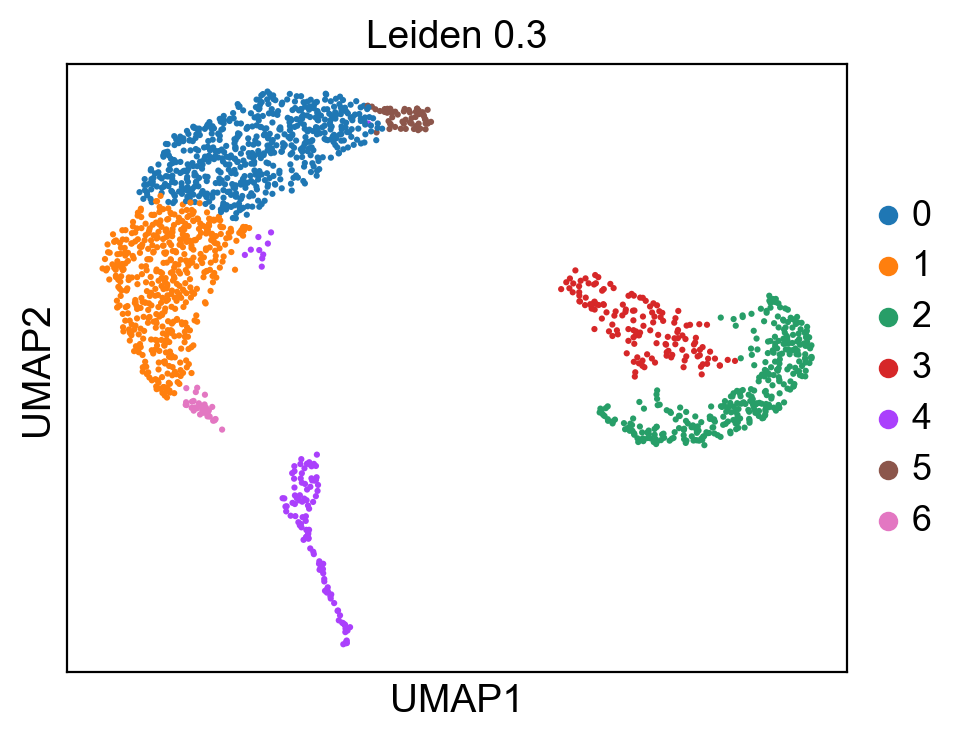

In [8]:
ep.settings.set_figure_params(figsize=(5, 4), dpi = 100)
ep.pl.umap(adata, color=["leiden_0_3"], title="Leiden 0.3",  size = 20)

This UMAP embedding is exactly the same as previously computed in the MIMIC-II IA tutorial. Now we continue with the patient fate analysis.

_________________

## Analysis using ehrapy

### Identifiying the origin using the Connectivity (Similarity) Kernel

Depending on the data it may not always be possible to clearly define a cluster or specific patient visits as the origin. When working with single-cell data this is easier because when stem cells are detected these are usually the origin of cell differentiation processes.

In our case we do not have any clear origin and will therefore start with cellrank's ConnectivityKernel (Smiliarity Kernel). This kernel computes transition probabilities based on similarities among patients using a KNN graph.
<br/><br/>

First we define the kernel, compute the transition matrix and a projection ontop of the UMAP.

In [9]:
%%capture 
from cellrank.kernels import ConnectivityKernel
ck = ConnectivityKernel(adata)
ck.compute_transition_matrix()
ck.plot_projection(basis="umap")

We can now visualize the project forwards and backwards in time using [scvelo](https://scvelo.readthedocs.io/).

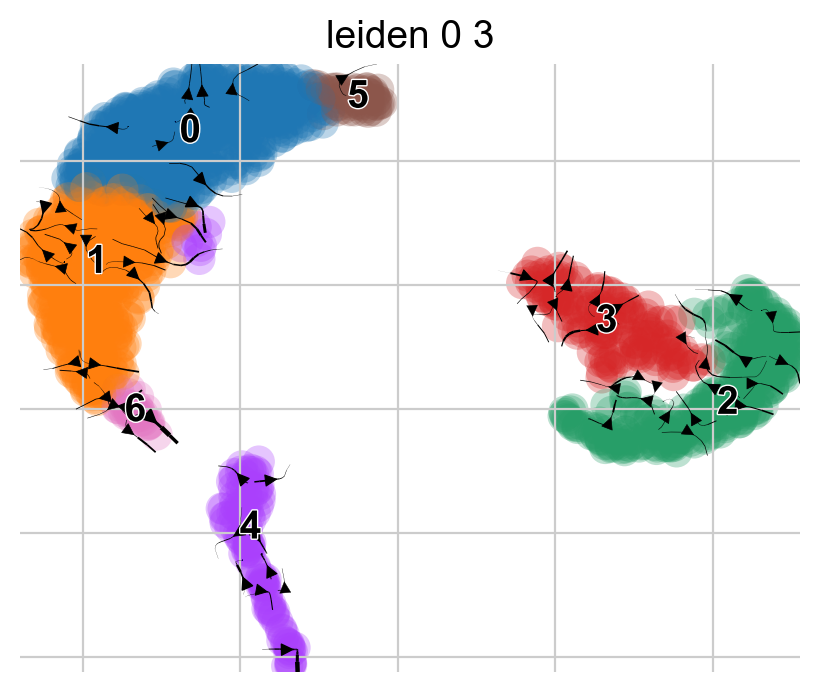

In [10]:
scv.pl.velocity_embedding_stream(adata, vkey="T_fwd", basis="umap", color="leiden_0_3")

We observe that several clusters including e.g. 2 only really have outgoing arrows indicating steady states. Let's check the metadata again. 

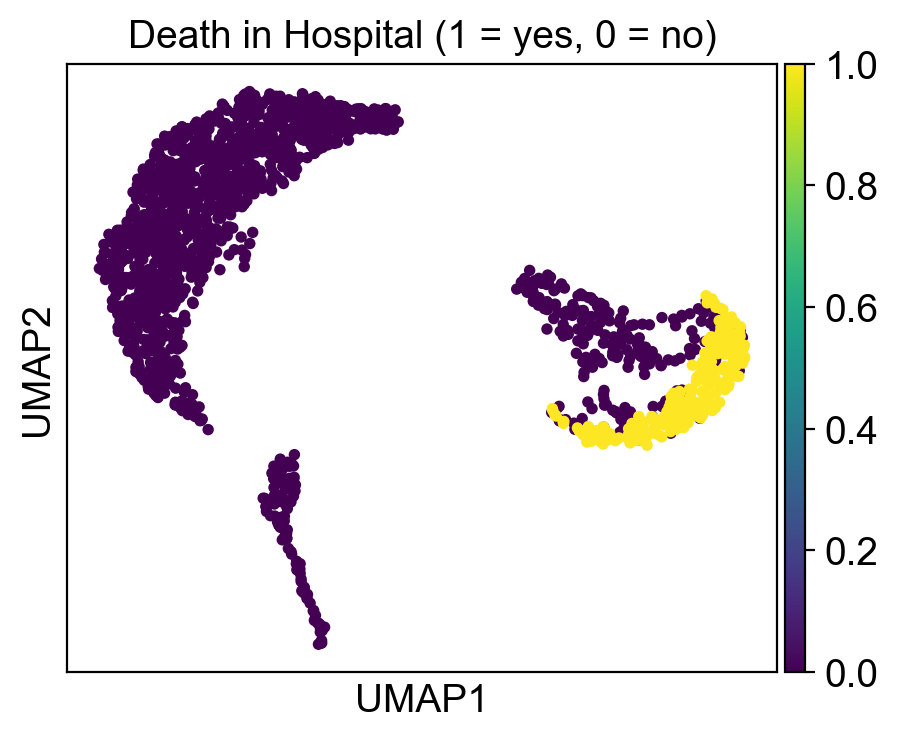

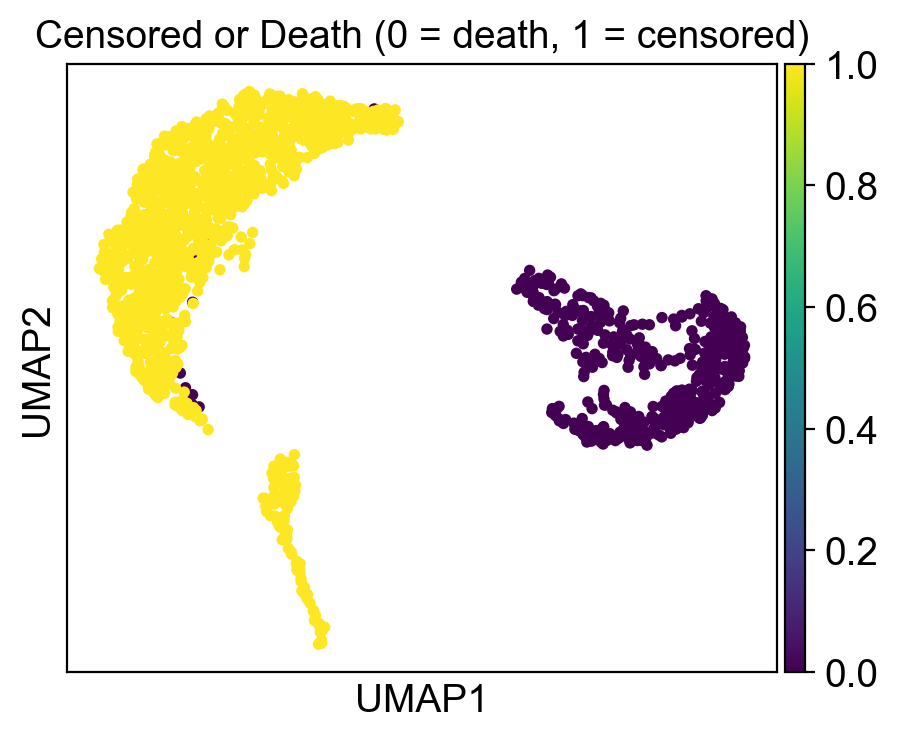

In [11]:
ep.pl.umap(adata, color = "hosp_exp_flg", title = "Death in Hospital (1 = yes, 0 = no)")
ep.pl.umap(adata, color = "censor_flg", title = "Censored or Death (0 = death, 1 = censored)")

Cluster 2 and 3 are the clusters where patients deceased and cluster 2 consists of patients that deceased in hospital.

To find the origins of this bad outcome clsters, well will use an estimator to predict the patient fates using the above calculated transition matrix. The main objective is to decompose the patient state space into a set of macrostates, that represent the slow-time scale dynamics of the process. Among these macrostates, we will identify initial and terminal states. Here, we will use an [**G**eneralized **P**erron **C**luster **C**luster **A**nalysis (GPCCA)](https://cellrank.readthedocs.io/en/latest/api/_autosummary/estimators/cellrank.estimators.GPCCA.html#cellrank.estimators.GPCCA) estimator.

### Determining macrostates and terminal states

In [12]:
g = cr.estimators.GPCCA(ck)
print(g)

GPCCA[kernel=ConnectivityKernel[n=1776], initial_states=None, terminal_states=None]


As a first step we try to identify macrostates in the data using the `fit()` function. Here, we can set the number of macrostates to identify (e.g. here `8`) or we provide a range, e.g. like `[5,10]`, and the function will choose the optimal number. 

In [13]:
g.fit(n_states = 8, cluster_key = "leiden_0_3")

GPCCA[kernel=ConnectivityKernel[n=1776], initial_states=None, terminal_states=None]

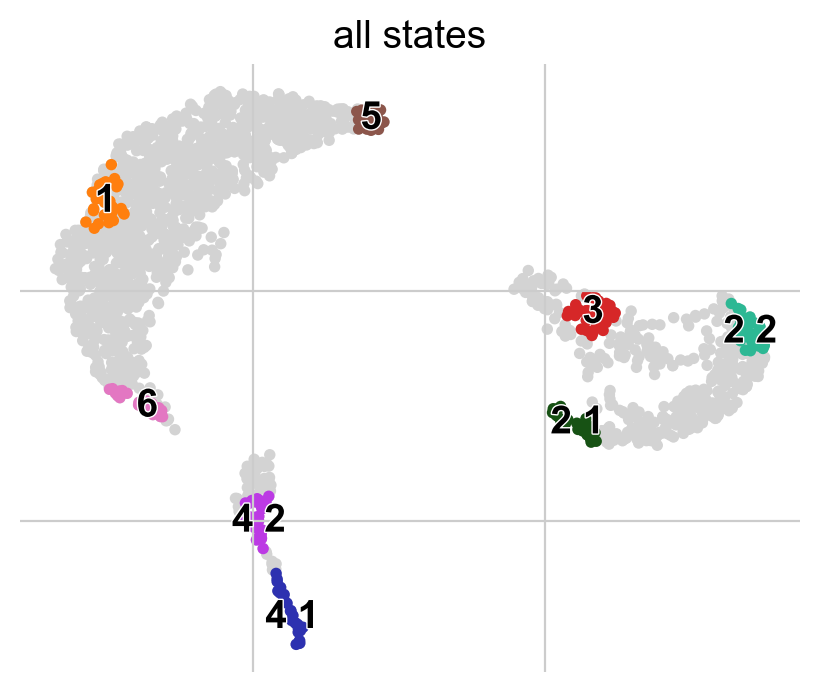

In [14]:
g.plot_macrostates(which = "all", discrete=True)

In [15]:
g.macrostates_memberships

Lineage([[9.60239655e-05, 3.71972182e-02, 4.52225970e-01, ...,
          2.34112530e-01, 1.04150146e-01, 5.03333062e-02],
         [2.03189016e-04, 5.54228616e-02, 1.13107987e-02, ...,
          3.23342991e-02, 9.63483126e-02, 6.11283534e-01],
         [3.61685637e-04, 4.20986228e-02, 1.10772761e-02, ...,
          3.33825445e-02, 1.55611067e-01, 6.16113138e-01],
         ...,
         [2.47496899e-05, 3.68879832e-02, 3.72266360e-02, ...,
          5.40972165e-01, 9.11565189e-02, 4.22100242e-02],
         [8.89350195e-06, 3.89771584e-02, 2.18611272e-01, ...,
          1.06284358e-01, 9.55810823e-02, 3.75151385e-02],
         [7.66207459e-05, 6.31622809e-02, 1.32000676e-02, ...,
          3.32556449e-02, 2.14268488e-02, 5.77619472e-01]],
  names([4_1, 4_2, 2_1, 3, 5, 2_2, 6, 1]))

When calculating 8 macrostates we notice that cluster 2 is split into two macrostates.

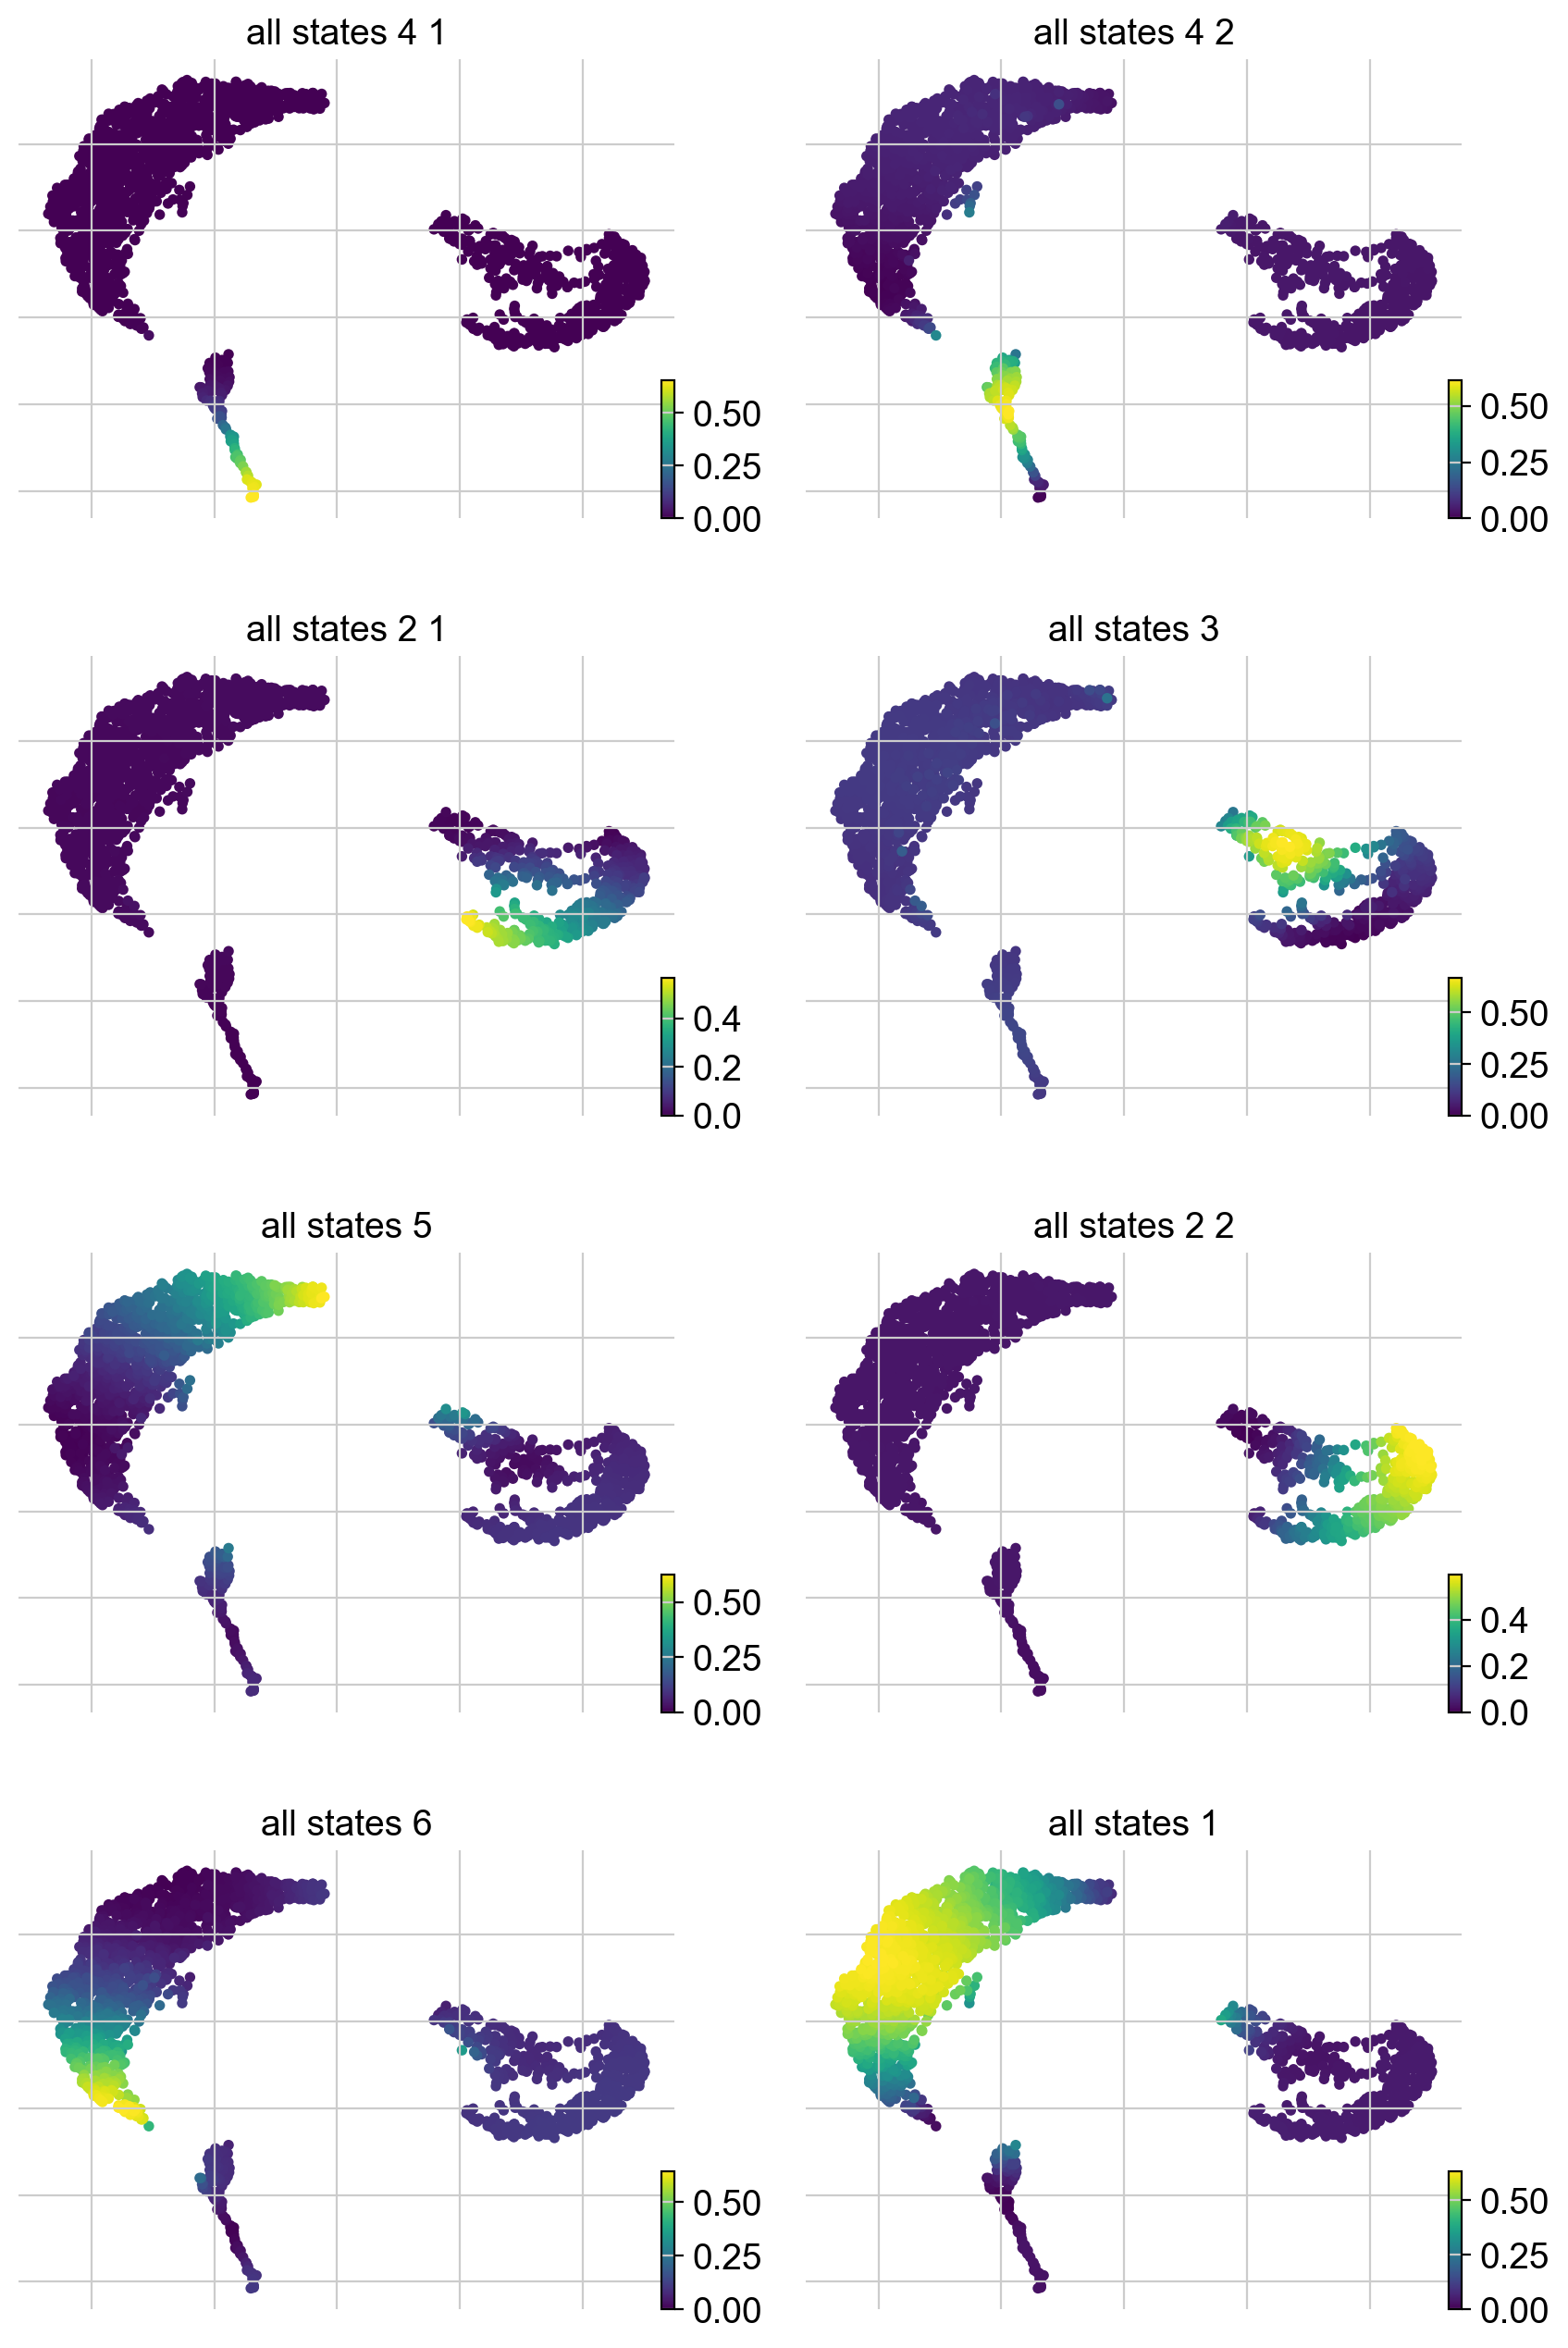

In [16]:
g.plot_macrostates(same_plot=False, ncols=2, which = "all", discrete=False)

We will now define the macrostates `2_1`, `2_2` and `3` as our terminal states. We can visualize only the terminal states with setting `which = "termial"` in the `plot_macrostates()` function. 

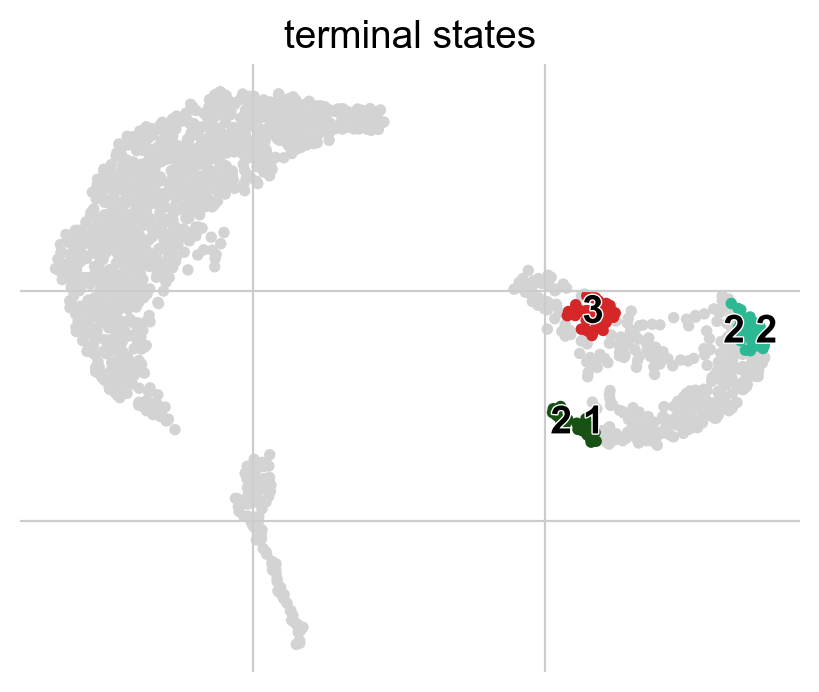

In [17]:
g.set_terminal_states(["2_1", "2_2", "3"])
g.plot_macrostates(which = "terminal", discrete=True)

### Calculating fate probabilities and absorption times

As a next step we will calculate the fate probabilities. For each patient visit, this computes the probability of being absorbed in any of the terminal states by aggregating over all random walks that start in a given patient visit and end in some termial population. 

In [18]:
g.compute_fate_probabilities()

Defaulting to `'gmres'` solver.


  0%|          | 0/3 [00:00<?, ?/s]

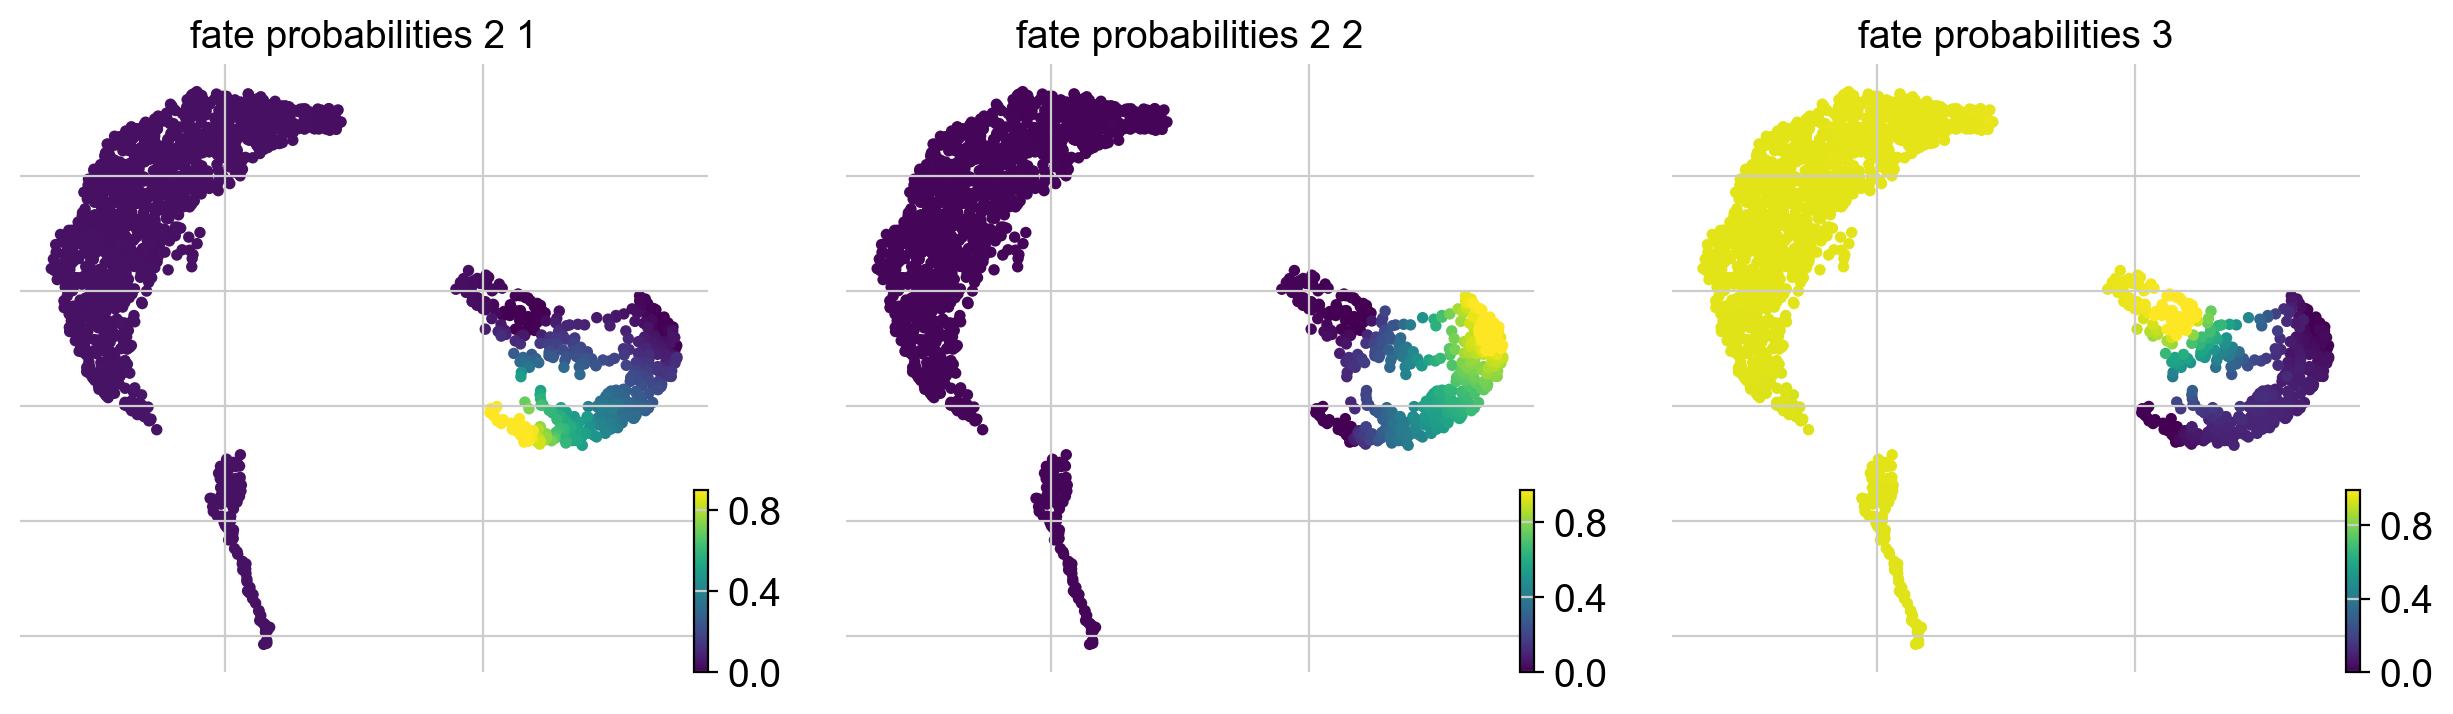

In [19]:
g.plot_fate_probabilities(same_plot=False)

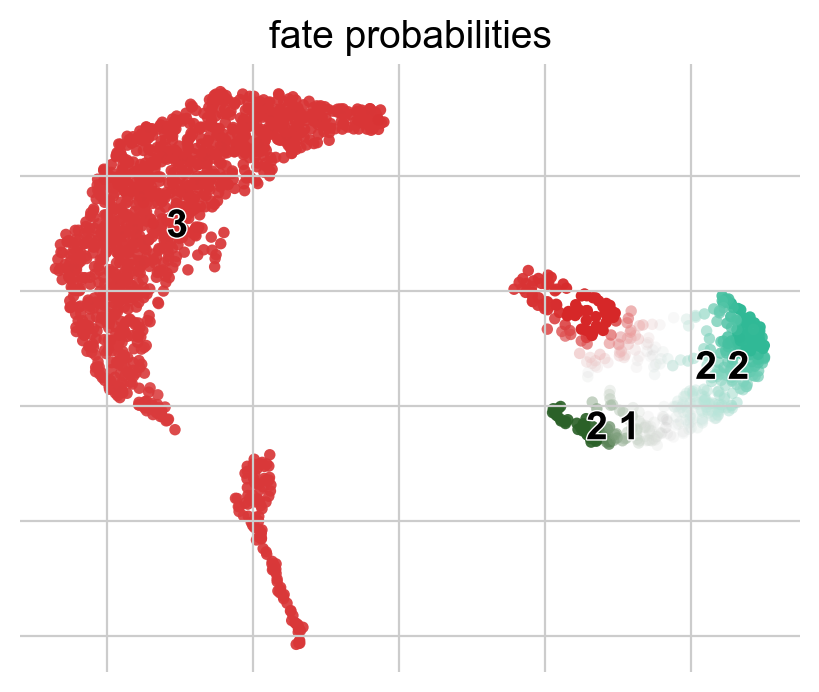

In [20]:
g.plot_fate_probabilities(same_plot=True)

The plot above combines fate probabilities towards all terminal states, each patient visit is colored according to its most likely fate, color intensity reflects the degree of fate priming.

We can also visualize the fate probabilities jointly in a circular projection where each dot represents a patient visit, colored by cluster labels. Patient visits are arranged inside the circle according to their fate probabilities, fate biased visits are placed next to their corresponding corner while undetermined patient fates are placed in the middle.

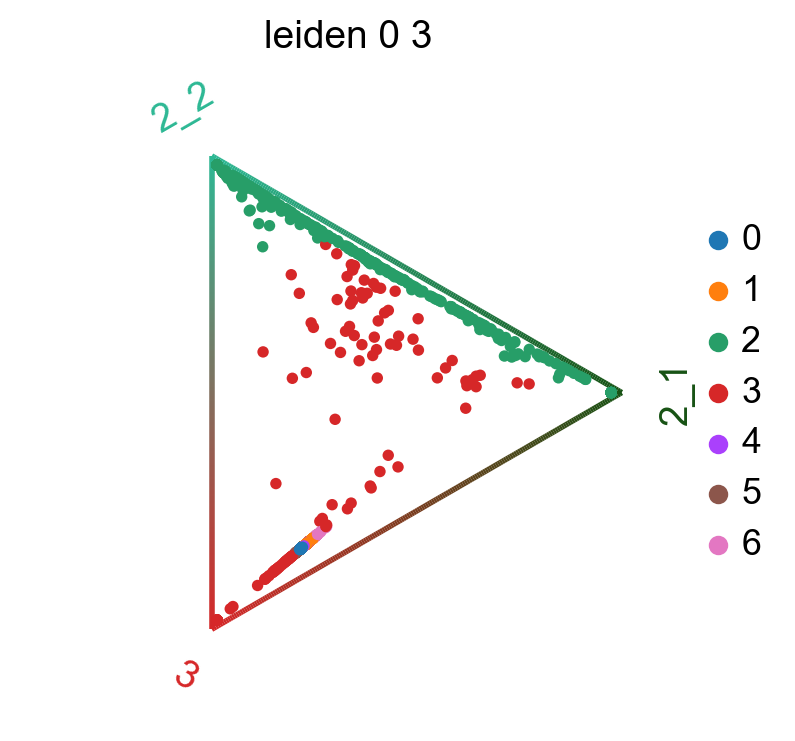

In [21]:
cr.pl.circular_projection(adata, keys="leiden_0_3", legend_loc="right")

We can also calculate the absorption times for each terminal state and then the mean time to absorption. 

In [22]:
g.compute_absorption_times(show_progress_bar = False)
g.absorption_times

2_1_mean     2_2_mean       3_mean
0       19.260562    81.832414   166.168020
1     2067.724055  2122.285955  2029.303065
2     2054.416169  2109.157551  2045.185163
3       68.250944    65.670404   148.667037
4     2099.941472  2152.930913  1841.322983
...           ...          ...          ...
1771    54.868929    71.849471   153.105897
1772    20.842311    81.136326   165.333472
1773    83.028116    15.702689    50.449112
1774    40.673587    84.854558   169.189643
1775  2098.582378  2153.069867  2022.373282

[1776 rows x 3 columns]

c:\Users\Knollr\Documents\github_ehrapy\.venv\Lib\site-packages\scvelo\plotting\utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


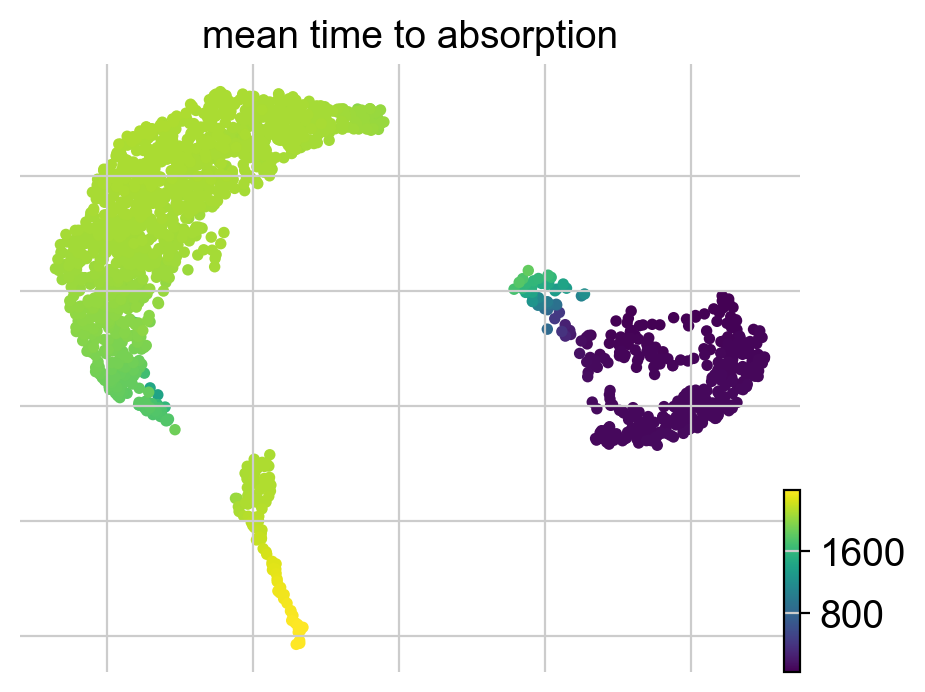

In [23]:
adata.obs["mean_time_to_absorption"] = g.absorption_times.mean(axis = 1)
scv.pl.scatter(adata, color="mean_time_to_absorption")

As a next step we want to determine the major features driving these transitions and terminal states.

### Identification of driver features

We uncover putative driver features by correlating fate probabilities with gene expression using the `compute_lineage_drivers()` method. In other words, if a feature is systematically higher or lower in patient vissits that are more or less likely to differentiate towards a given terminal states, respectively, then we call this feature a putative driver feature.

In [24]:
drivers_2_2 = g.compute_lineage_drivers(lineages="2_2")
drivers_2_2.head(10)

2_2_corr       2_2_pval       2_2_qval  2_2_ci_low  2_2_ci_high
day_28_flg    0.777018   0.000000e+00   0.000000e+00    0.757896     0.794805
hosp_exp_flg  0.729049   0.000000e+00   0.000000e+00    0.706493     0.750125
icu_exp_flg   0.604363  6.100239e-191  6.466254e-190    0.573984     0.633080
age           0.371726   9.957518e-61   8.795807e-60    0.330934     0.411131
sapsi_first   0.325949   4.861519e-46   3.680864e-45    0.283737     0.366900
stroke_flg    0.304757   4.311831e-40   2.856588e-39    0.261957     0.346361
afib_flg      0.246771   2.684757e-26   1.422921e-25    0.202582     0.289956
bun_first     0.206012   1.362279e-18   6.563710e-18    0.161041     0.250129
sofa_first    0.158930   1.485727e-11   6.561960e-11    0.113254     0.203936
chf_flg       0.153913   6.458510e-11   2.633085e-10    0.108174     0.199002

c:\Users\Knollr\Documents\github_ehrapy\.venv\Lib\site-packages\ehrapy\_settings.py:403: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
c:\Users\Knollr\Documents\github_ehrapy\.venv\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


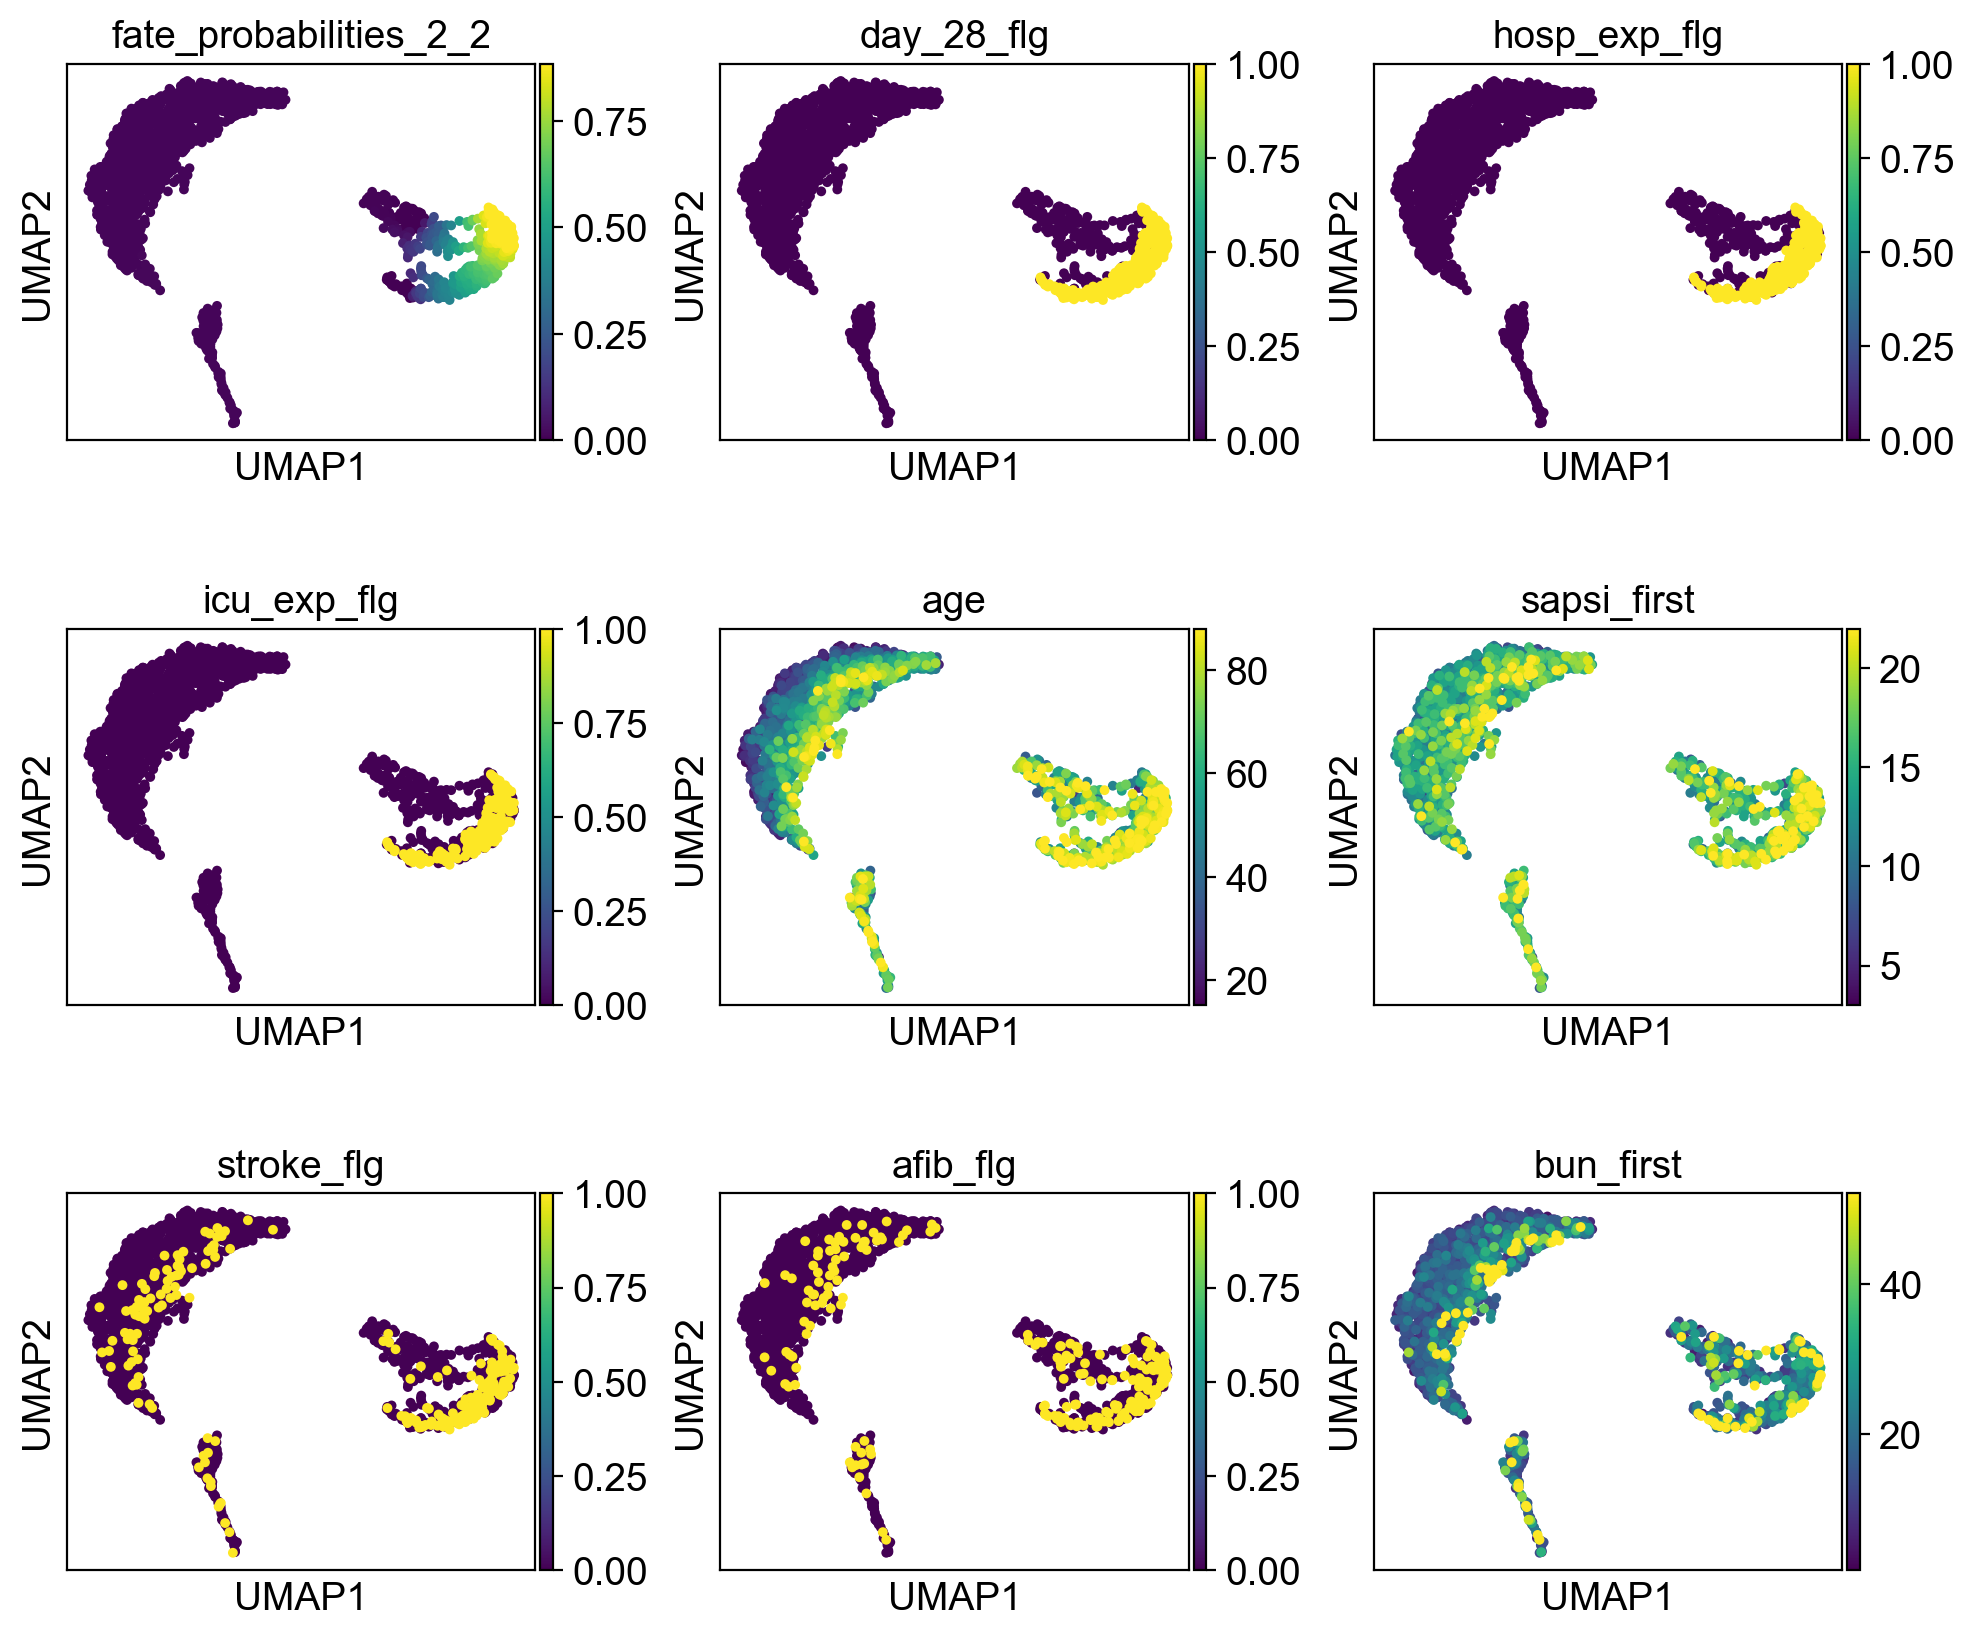

In [25]:
ep.settings.set_figure_params(figsize=(3, 3), dpi = 100)
adata.obs["fate_probabilities_2_2"] = g.fate_probabilities["2_2"].X.flatten()

ep.pl.embedding(
    adata,
    basis="umap",
    color=["fate_probabilities_2_2"] + list(drivers_2_2.index[:8]),
    color_map="viridis",
    s=50,   hspace = 0.5,
    ncols=3, size = 1, 
    vmax="p96",
)

c:\Users\Knollr\Documents\github_ehrapy\.venv\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


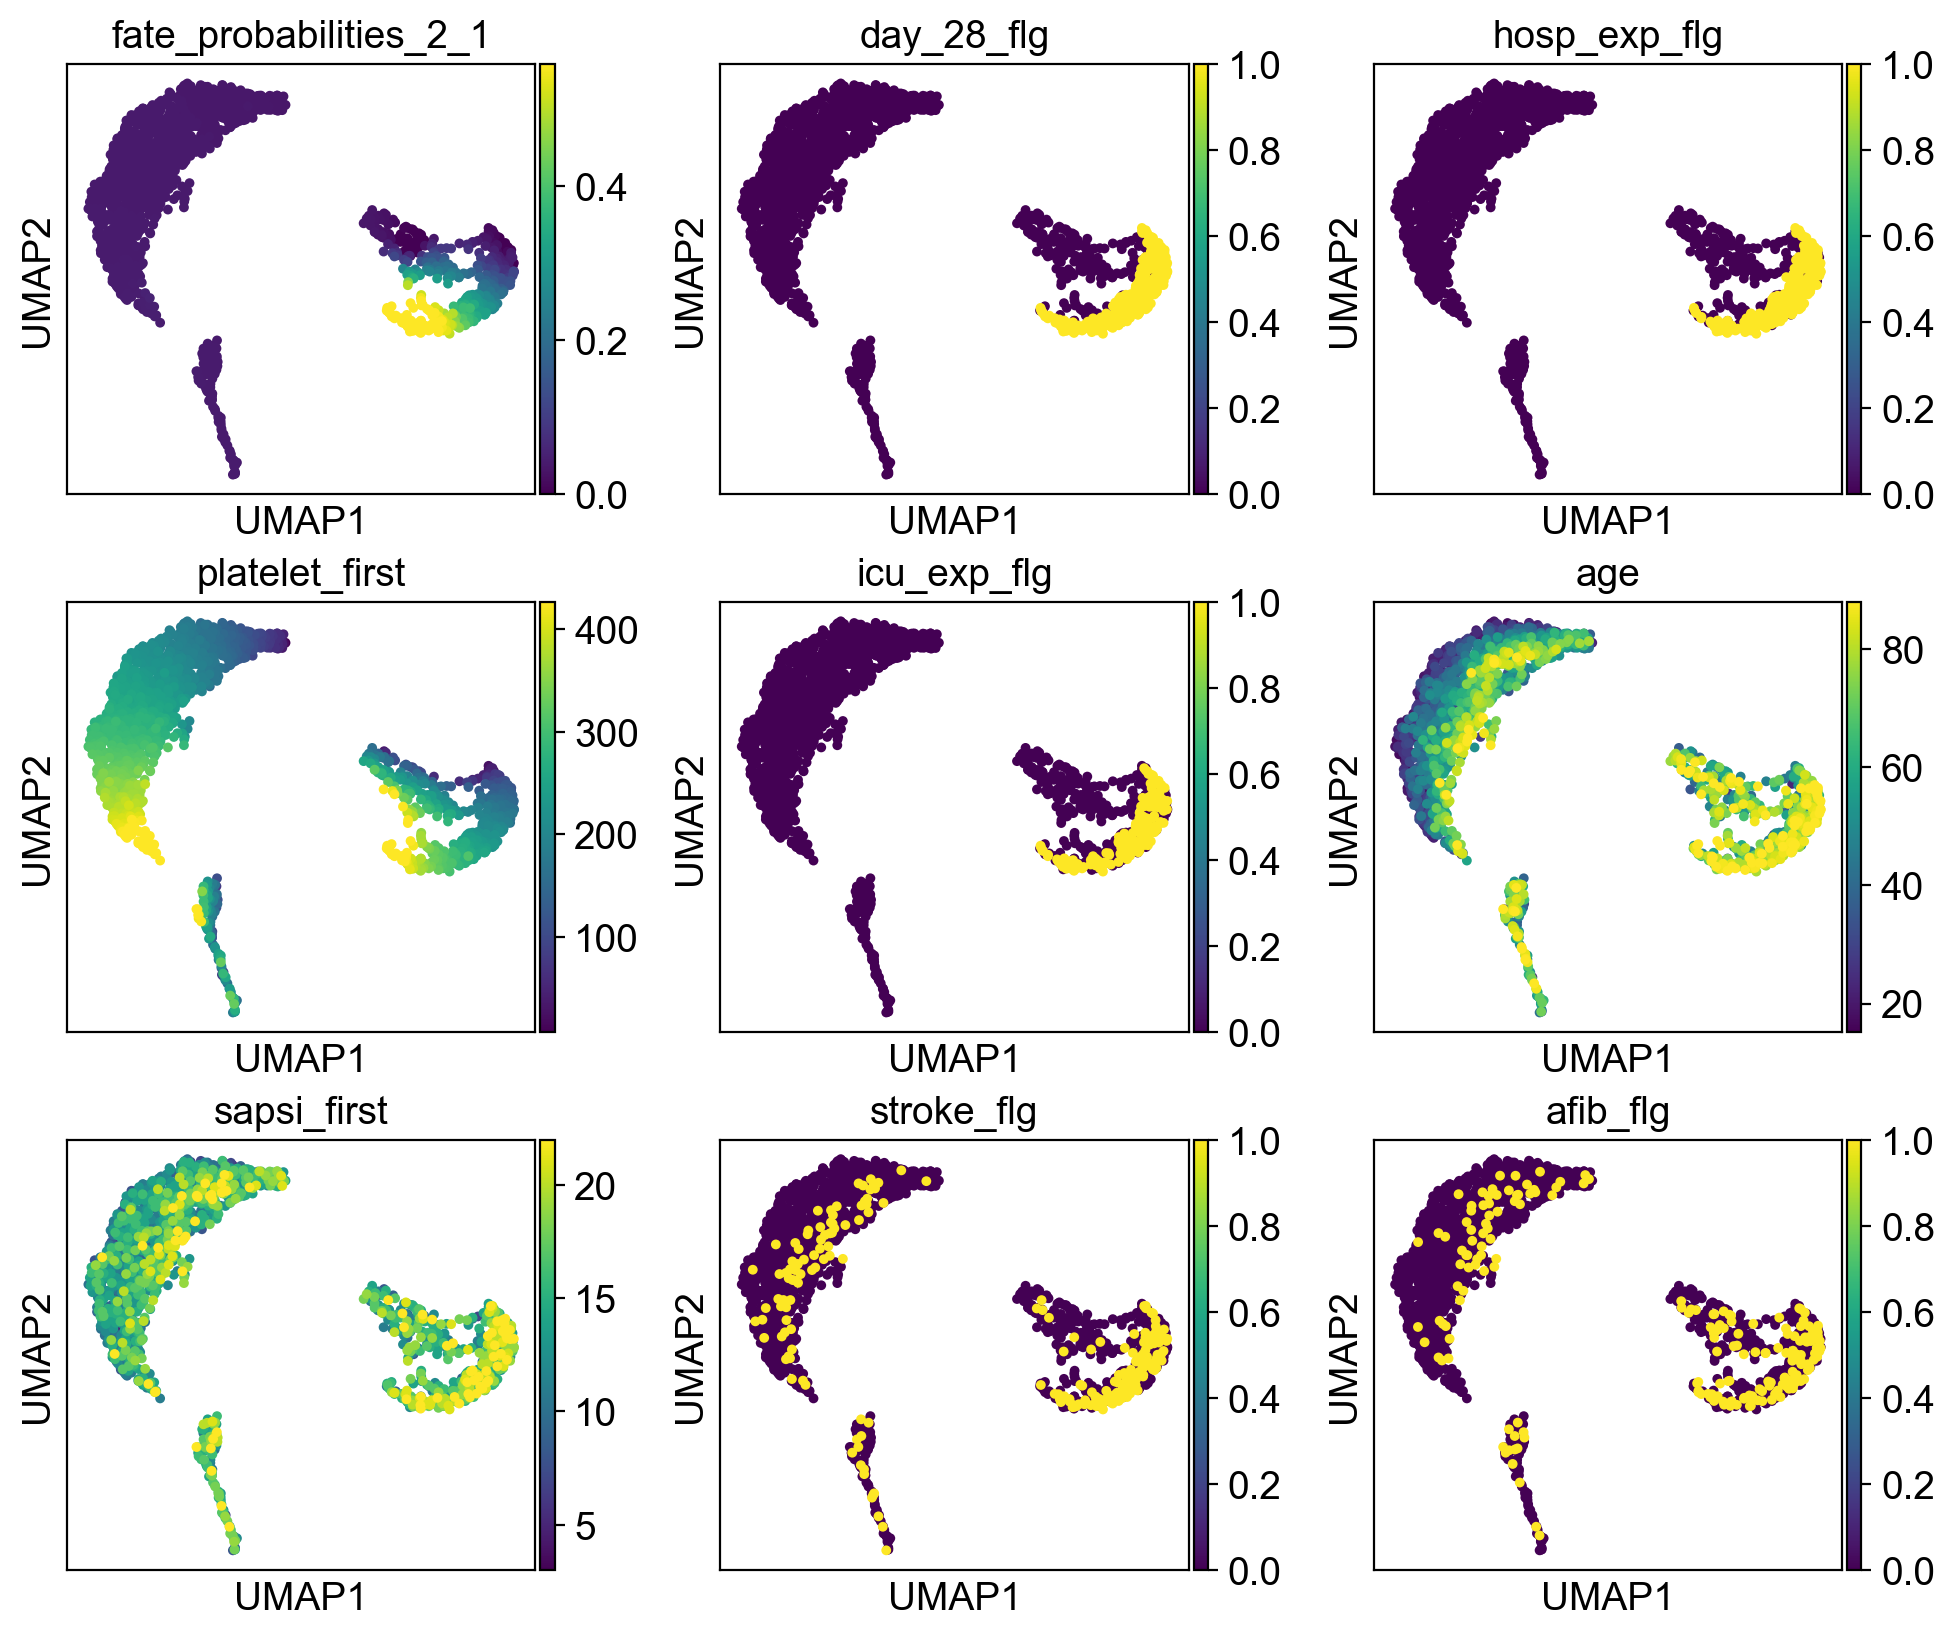

In [26]:
drivers_2_1 = g.compute_lineage_drivers(lineages="2_1")
adata.obs["fate_probabilities_2_1"] = g.fate_probabilities["2_1"].X.flatten()

ep.pl.embedding(
    adata,
    basis="umap",
    color=["fate_probabilities_2_1"] + list(drivers_2_1.index[:8]),
    color_map="viridis",
    s=50,
    ncols=3,
    vmax="p96",
)

c:\Users\Knollr\Documents\github_ehrapy\.venv\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


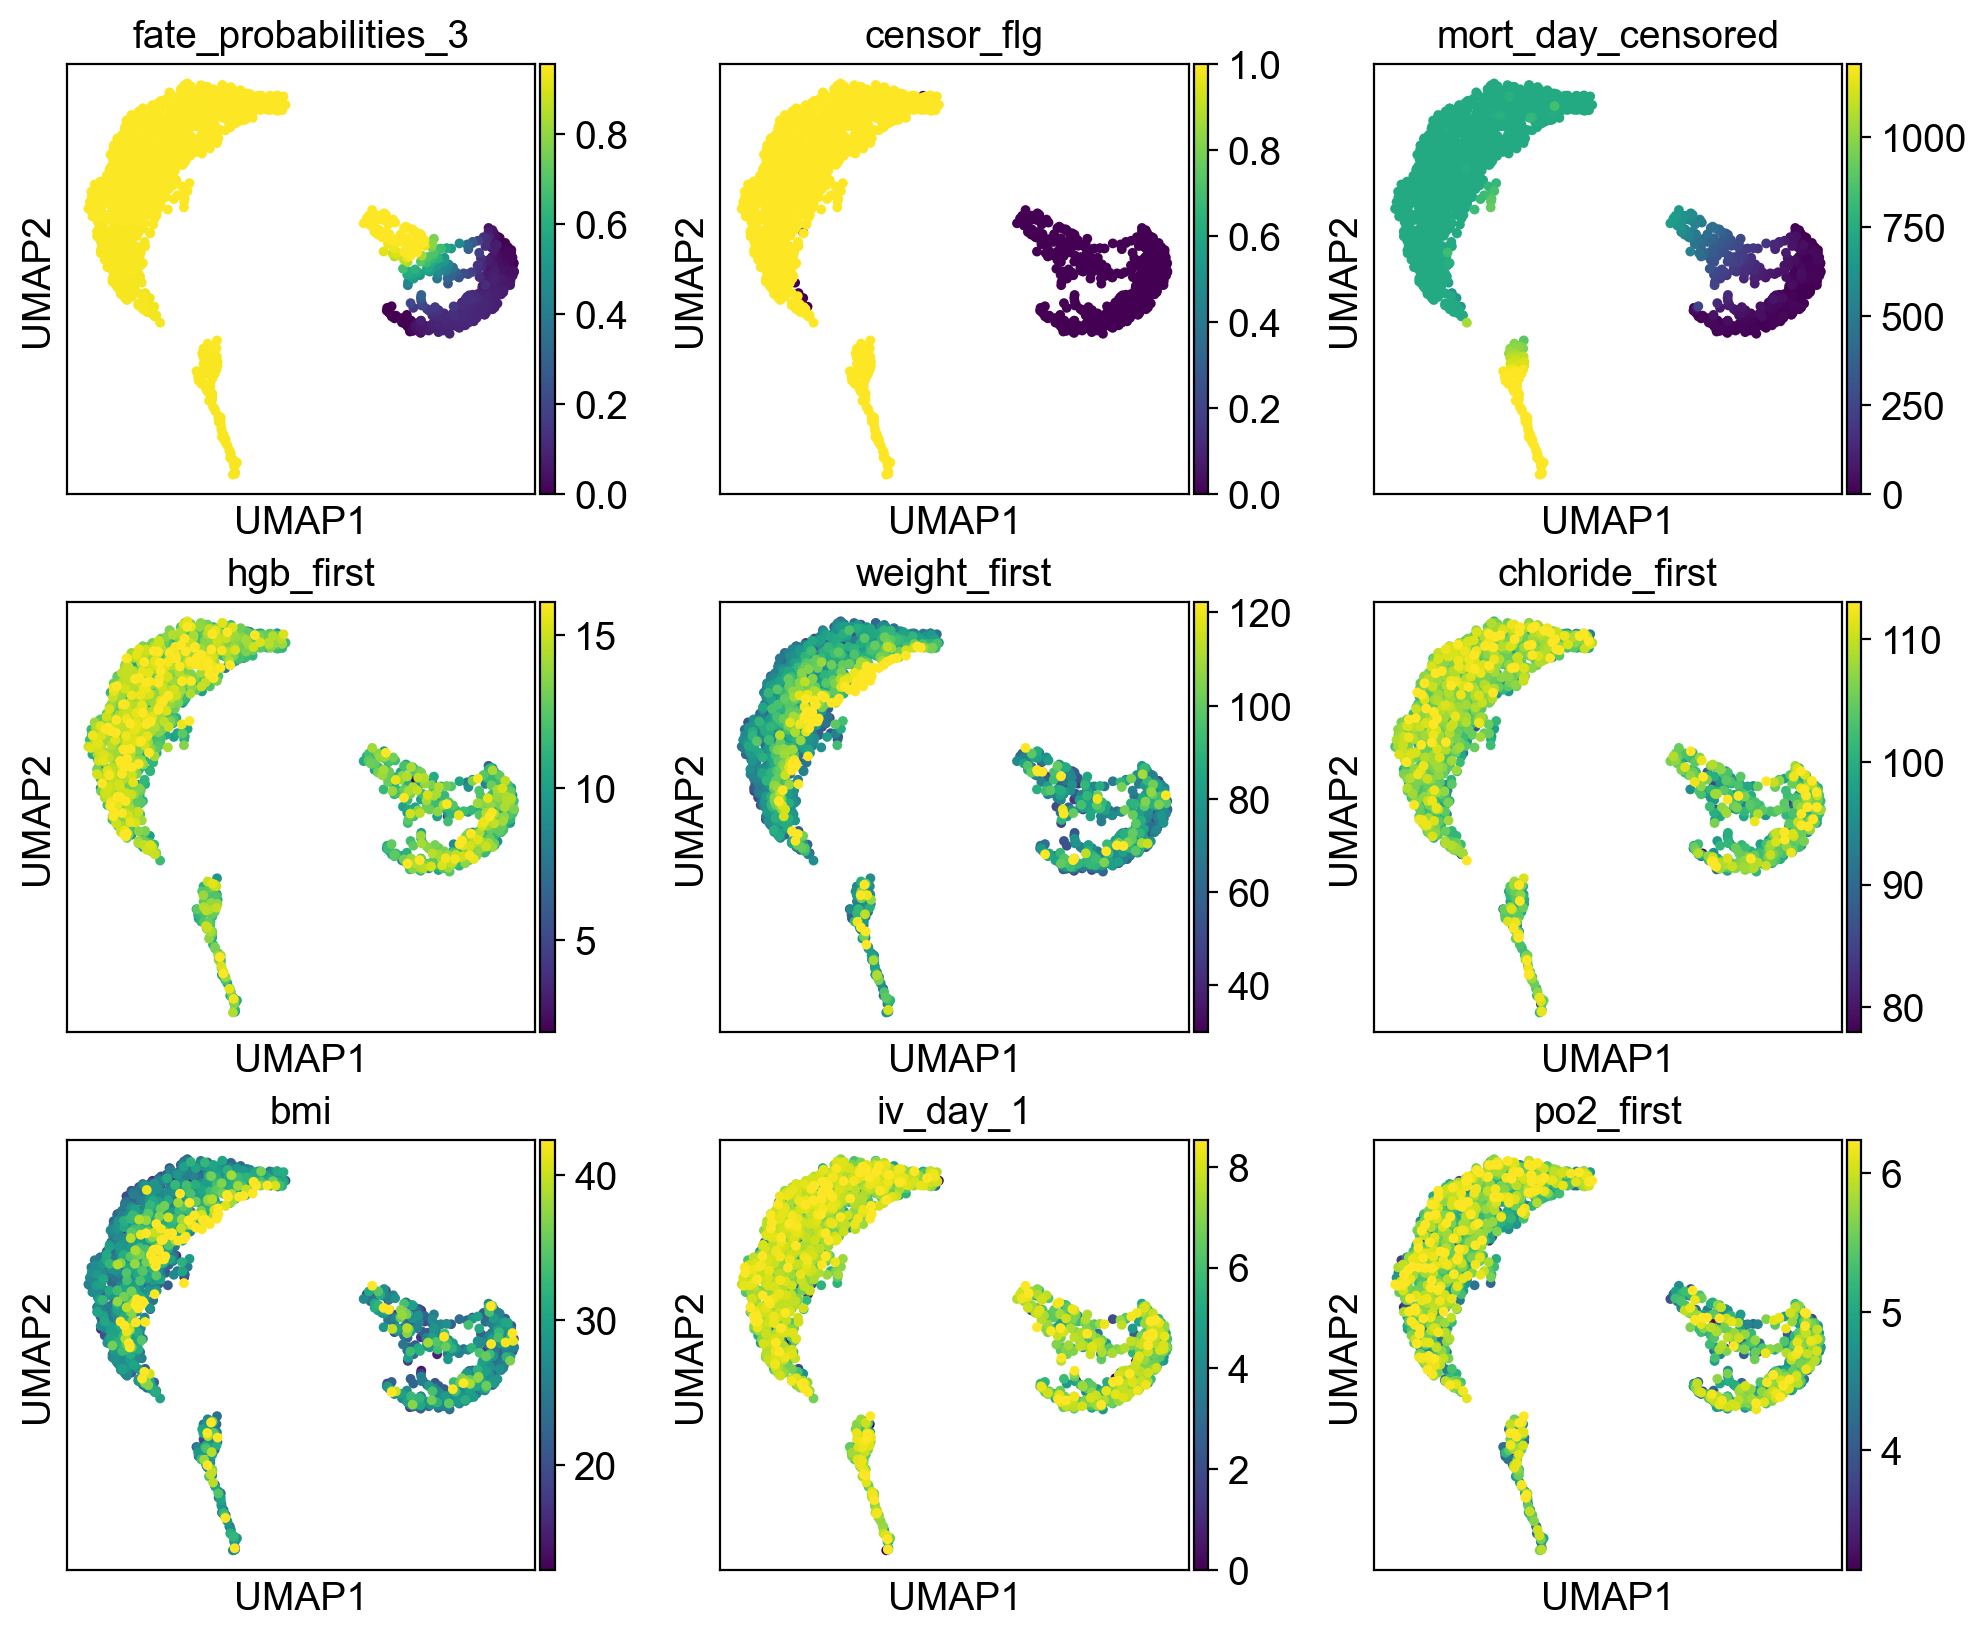

In [27]:
drivers_3 = g.compute_lineage_drivers(lineages="3")
adata.obs["fate_probabilities_3"] = g.fate_probabilities["3"].X.flatten()

ep.pl.embedding(
    adata,
    basis="umap",
    color=["fate_probabilities_3"] + list(drivers_3.index[:8]),
    color_map="viridis",
    s=50,
    ncols=3,
    vmax="p96",
)

The macrosatate 2_2 seems to have a lot of patients that deceased in hospital, are of high age, had a high first SAPS I score and a stroke, while macrostate 2_1 consists of patients that deceased in hospital and had a high platelet measurement and macrostate 3 consists of deceased patients that had low hemoglobin.

Although some of the features overlap as drivers for death as a terminal state, all three clusters have unique origins of their macrostates.

To further plot the cluster fates, we can also visualize the fate probabilities by bar plots for each cluster. 

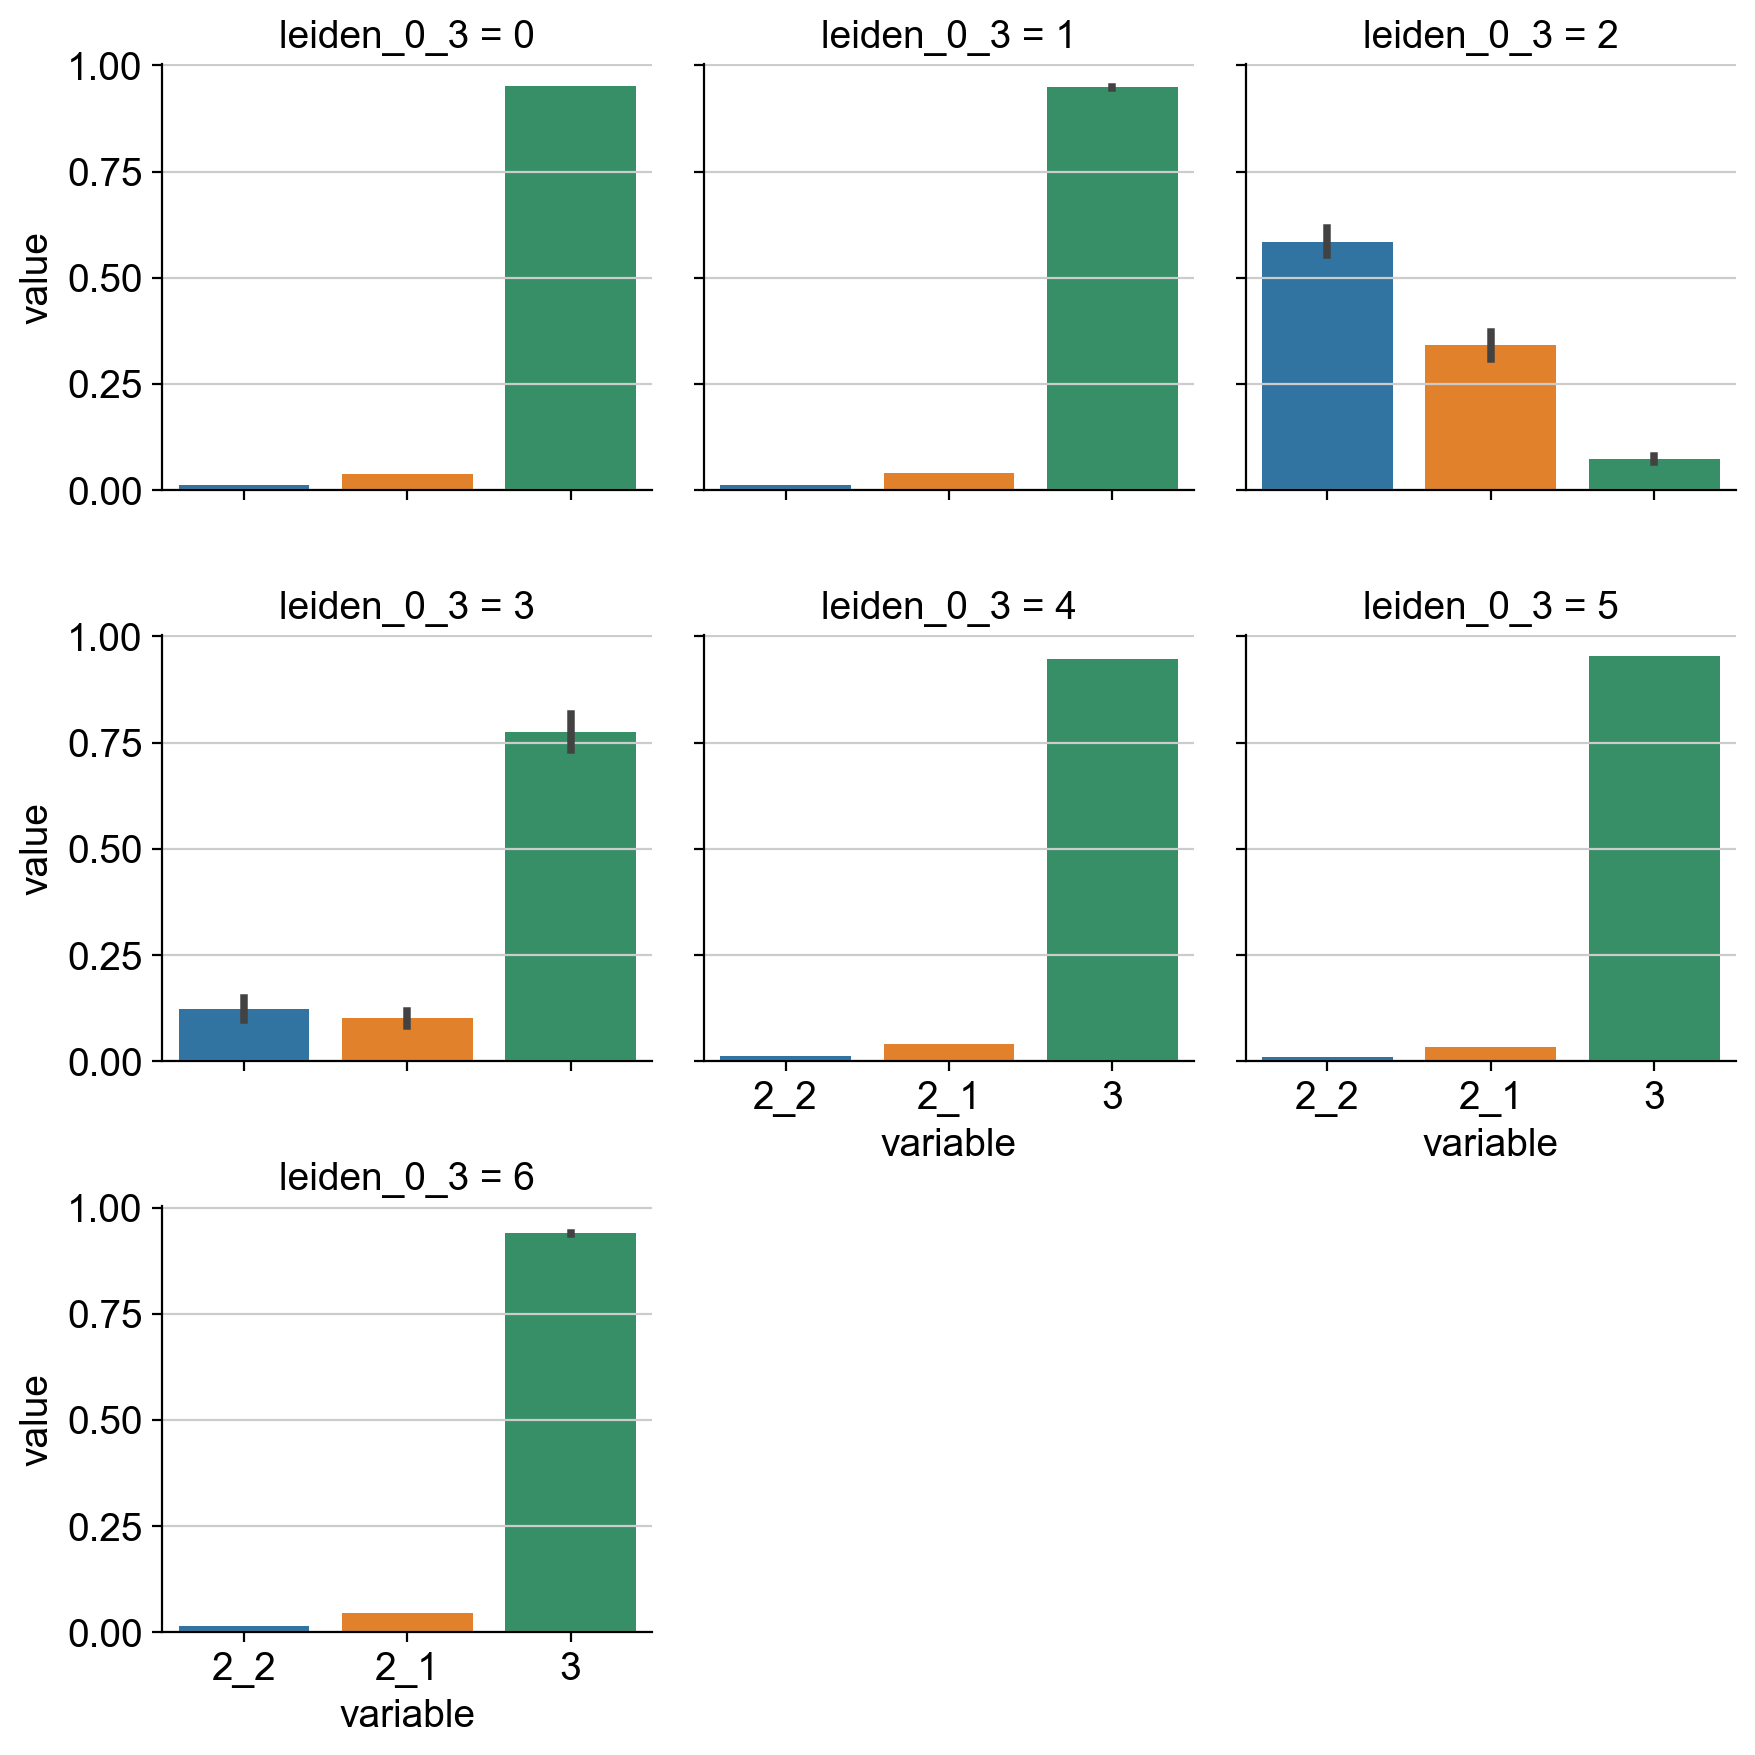

In [28]:
df = adata.obs.loc[:, ["leiden_0_3", "fate_probabilities_2_2",	"fate_probabilities_2_1",	"fate_probabilities_3"]]
df = df.rename(columns={"fate_probabilities_2_2": "2_2", "fate_probabilities_2_1": "2_1", "fate_probabilities_3": "3"})
df = df.melt(id_vars = ["leiden_0_3"], value_vars = ["2_2", "2_1", "3"])
sns.catplot(data = df, kind = "bar", x = "variable", y = "value", col = "leiden_0_3", col_wrap = 3,  height=3, aspect=1)

### Determining patient fate with a PseudotimeKernel

### Exploring cluster fates

We have now learnt that for example death dominated cluster 7 origins from cluster 10 (high IV).
Hence, we will now set a patient from cluster 10 as our root for our pseudotime calculation and will verify that we would indeed end up in clusters 4, 7 and 8.

Using pseudotime to find terminal states is even more useful when the terminal states are unknown and only a root cluster is clear.

In [51]:
%%capture 
adata = ep.dt.mimic_2(encoded=False)
adata = ep.pp.encode(adata, encodings={"one_hot_encoding": ["service_unit", "day_icu_intime"]})
ep.pp.knn_impute(adata, n_neighbours=5)
ep.pp.log_norm(adata, vars=['iv_day_1', "po2_first"], offset=1)
ep.pp.pca(adata)
ep.pp.neighbors(adata, n_pcs=10)
ep.tl.umap(adata)
ep.tl.leiden(adata, resolution=0.3, key_added="leiden_0_3")

2023-08-08 13:45:35,279 - root INFO - Added all columns to `obs`.
2023-08-08 13:45:35,296 - root INFO - Transformed passed dataframe into an AnnData object with n_obs x n_vars = `1776` x `46`.
2023-08-08 13:45:35,298 - root INFO - The original categorical values `['service_unit', 'day_icu_intime']` were added to uns.


2023-08-08 13:45:35,322 - root INFO - Updated the original layer after encoding.
2023-08-08 13:45:35,329 - root INFO - Added `['service_unit', 'day_icu_intime']` columns to `X`.
2023-08-08 13:45:35,338 - root INFO - The original categorical values `['service_unit', 'day_icu_intime']` were added to obs.
2023-08-08 13:45:35,496 - root INFO - Added the calculated metrics to AnnData's `obs` and `var`.
2023-08-08 13:45:35,676 - root INFO - Column names for numeric variables ['iv_day_1', 'po2_first'] were replaced by [[5.2832036 7.7105975]
 [5.1973915 6.398595 ]
 [5.7004437 7.643866 ]
 ...
 [5.757007  5.0657544]
 [4.4426513 3.125444 ]
 [6.35437   8.38229  ]].


c:\Users\Knollr\Documents\github_ehrapy\.venv\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


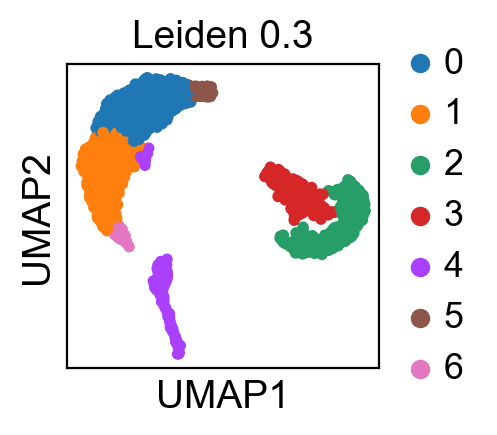

In [52]:
ep.pl.umap(adata, color=["leiden_0_3"], title="Leiden 0.3")

### Pseudotime Kernels and stream embeddings

The Pseudotime kernel computes direct transition probabilities based on a KNN graph and pseudotime.

The KNN graph contains information about the (undirected) connectivities among cells, reflecting their similarity. Pseudotime can be used to either remove edges that point against the direction of increasing pseudotime, or to downweight them.

In [56]:
adata.uns["iroot"] = np.flatnonzero(adata.obs["leiden_0_3"] == "0")[0]
ep.tl.dpt(adata)

In [57]:
%%capture 
from cellrank.kernels import PseudotimeKernel
pk = PseudotimeKernel(adata, time_key = "dpt_pseudotime")
pk.compute_transition_matrix()
pk.plot_projection(basis="umap")

c:\Users\Knollr\Documents\github_ehrapy\.venv\Lib\site-packages\ehrapy\_settings.py:403: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


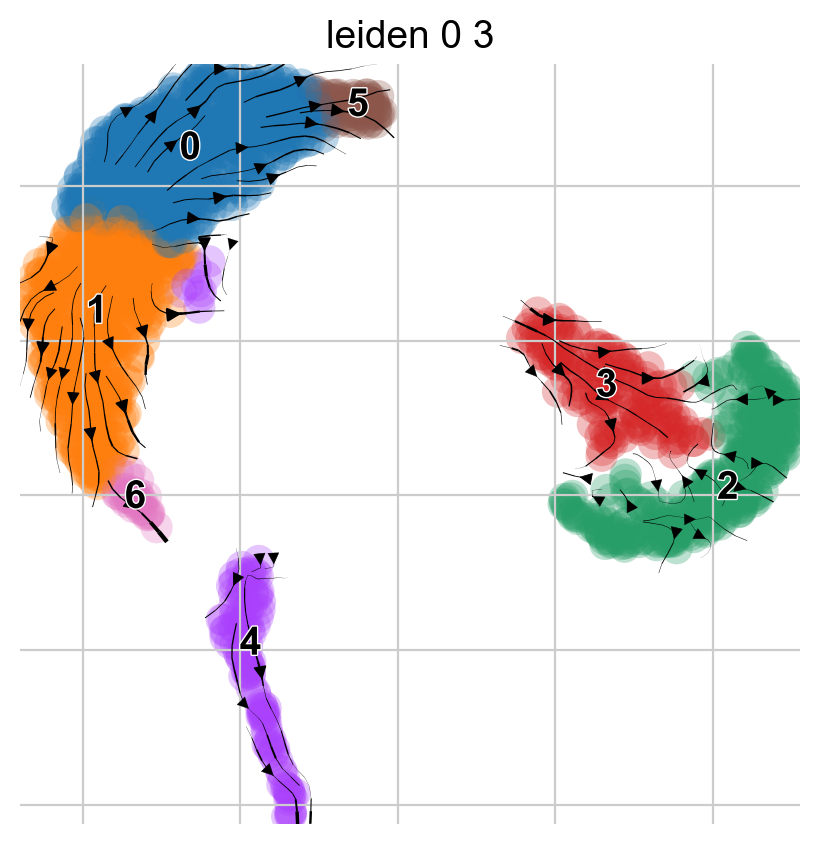

In [58]:
ep.settings.set_figure_params(figsize=(5, 5), dpi = 100)
scv.pl.velocity_embedding_stream(adata, vkey="T_fwd", basis="umap", color="leiden_0_3")

Now the arrows are much more clear and point into the direction of clusters 2 and 3 from cluster 0.

### Simulating transitions with random walks

Cellrank makes it easy to simulate the behavior of random walks from specific clusters.
This allows us to not only visualize where the patients end up, but also roughly how many in which clusters after a defined number of iterations.
We can either just start walking...

  0%|          | 0/100 [00:00<?, ?sim/s]

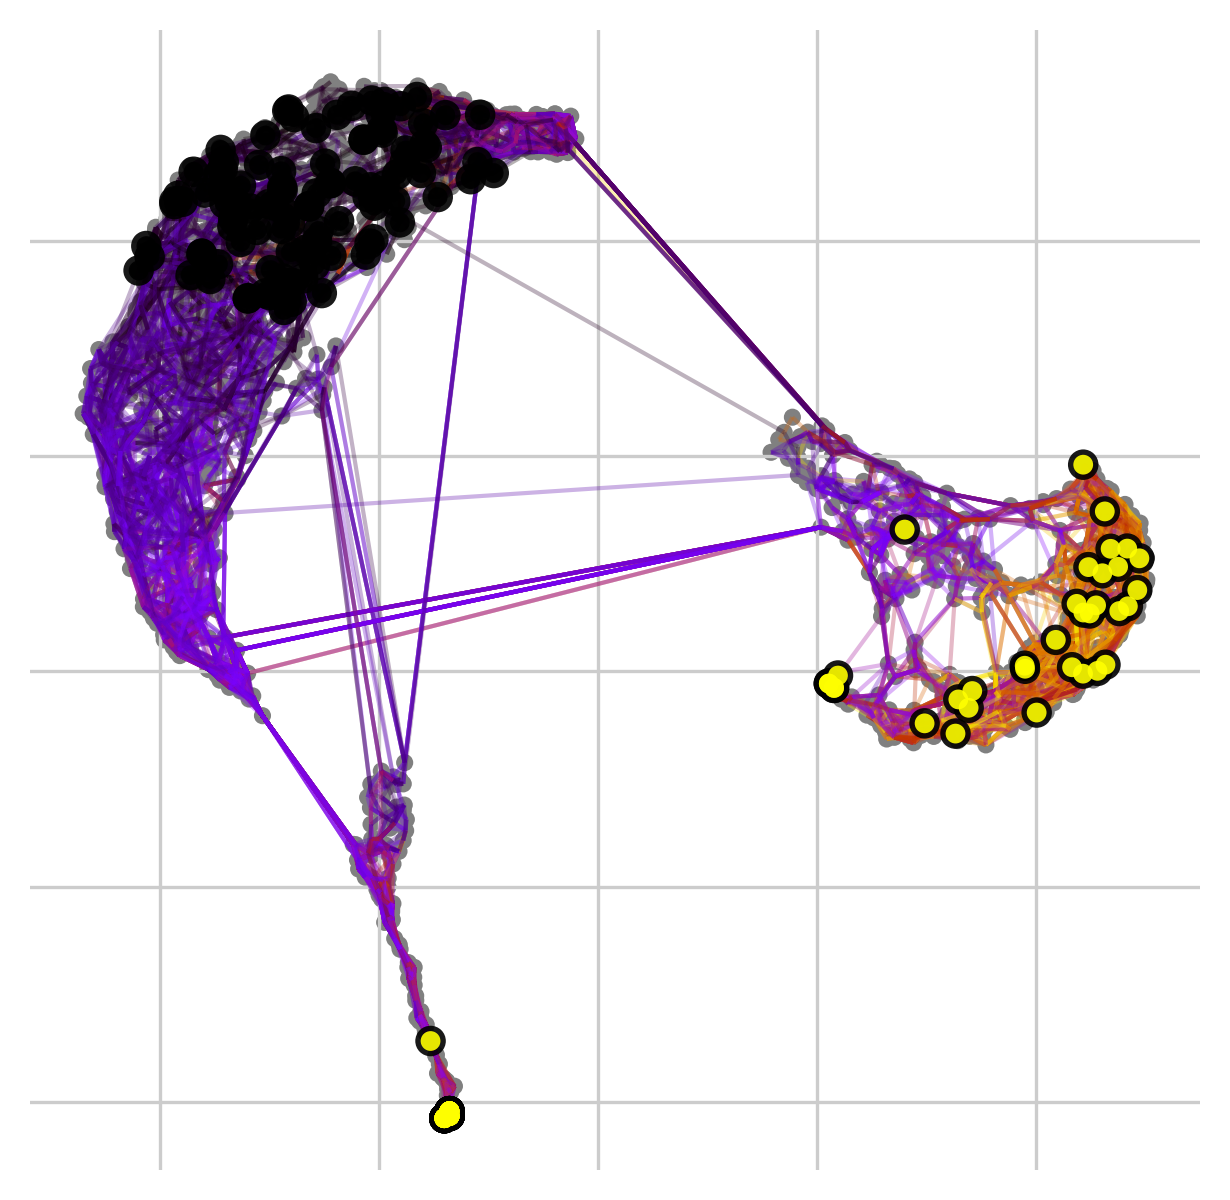

In [60]:
pk.plot_random_walks(
    seed=0,
    n_sims=100,
    start_ixs={"leiden_0_3": ["0"]},
    legend_loc="right",
    dpi=150,
)

... or set a number of required hits in one or more terminal clusters.
Here, we require 50 hits in one of our "death" clusters.

  0%|          | 0/100 [00:00<?, ?sim/s]

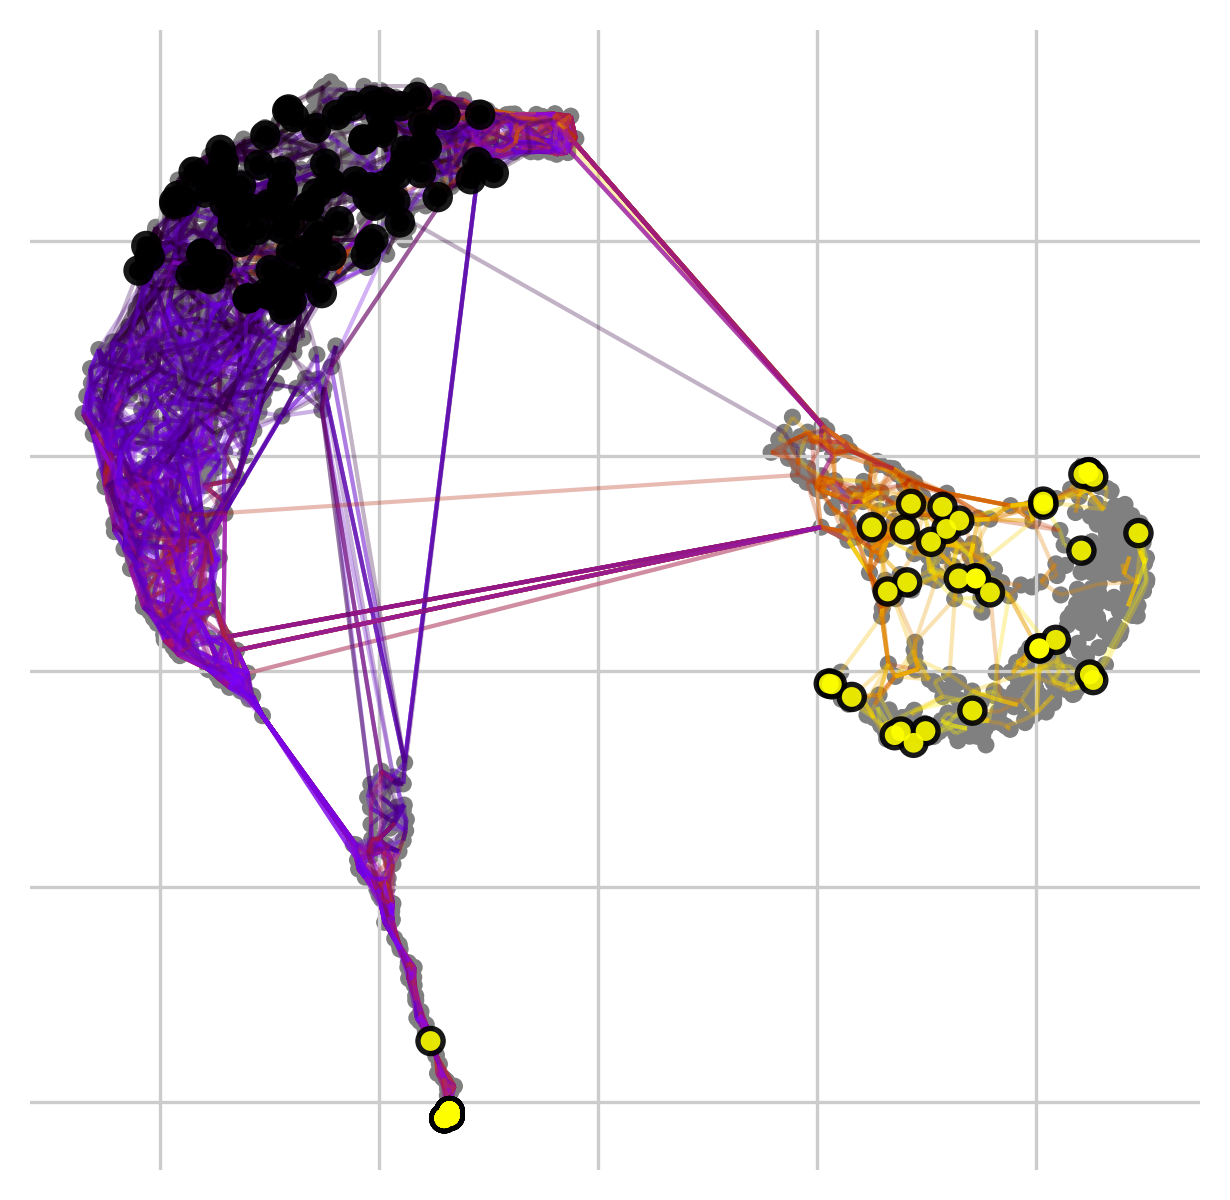

In [63]:
pk.plot_random_walks(
    seed=0,
    n_sims=100,
    start_ixs={"leiden_0_3": ["0"]},
    stop_ixs={"leiden_0_3": ["2", "3"]},   
    successive_hits = 50,
    legend_loc="right",
    dpi=150,
)

### Determining macrostates and terminal states

Similarly to above when using our ConnectivityKernel we can compute macrostate memberships.

In [73]:
g = cr.estimators.GPCCA(pk)
g.fit(cluster_key="leiden_0_3")
g.macrostates_memberships

Lineage([[2.6991670795e-01, 7.2993229125e-01, 1.5100079823e-04],
         [3.1572919096e-02, 1.9743837552e-01, 7.7098870539e-01],
         [3.2702236402e-02, 1.9019691843e-01, 7.7710084517e-01],
         ...,
         [1.0151440386e-02, 9.8982114018e-01, 2.7419432090e-05],
         [2.8493254352e-01, 7.0979383300e-01, 5.2736234778e-03],
         [3.0109056390e-02, 2.3781861089e-01, 7.3207233272e-01]],
  names([2_1, 2_2, 4]))

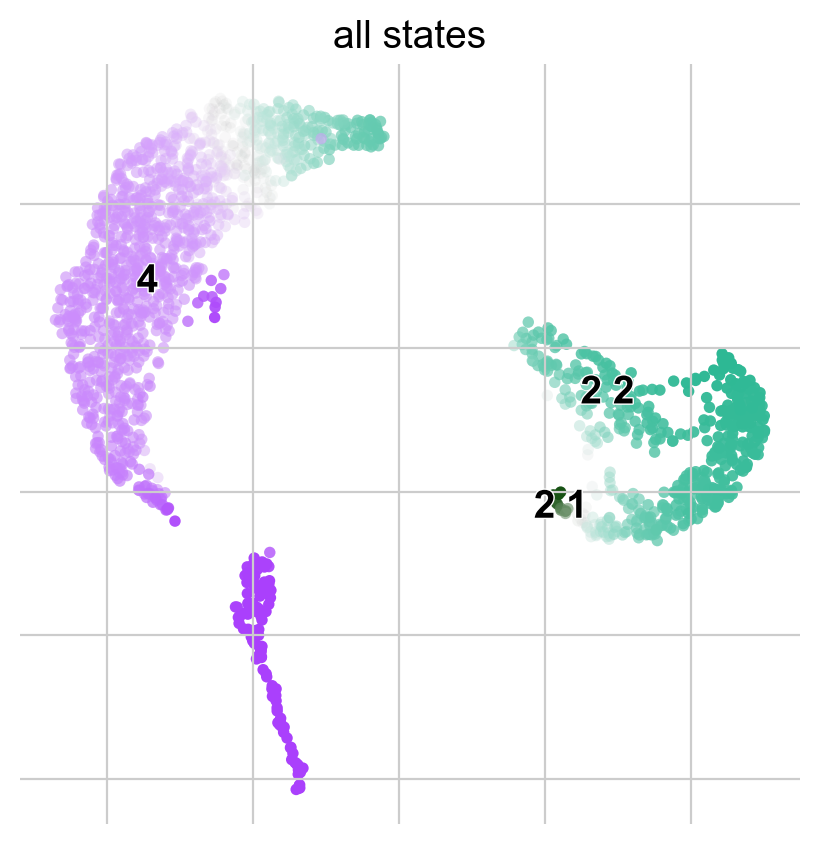

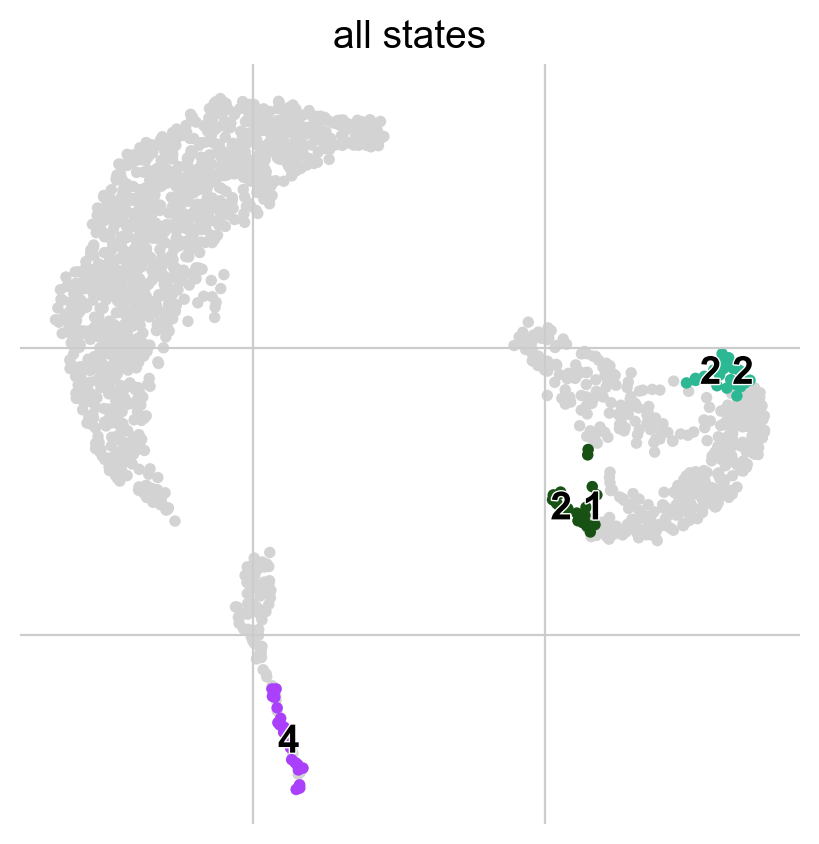

In [75]:
g.plot_macrostates(which = "all", discrete=False)
g.plot_macrostates(which = "all", discrete=True)

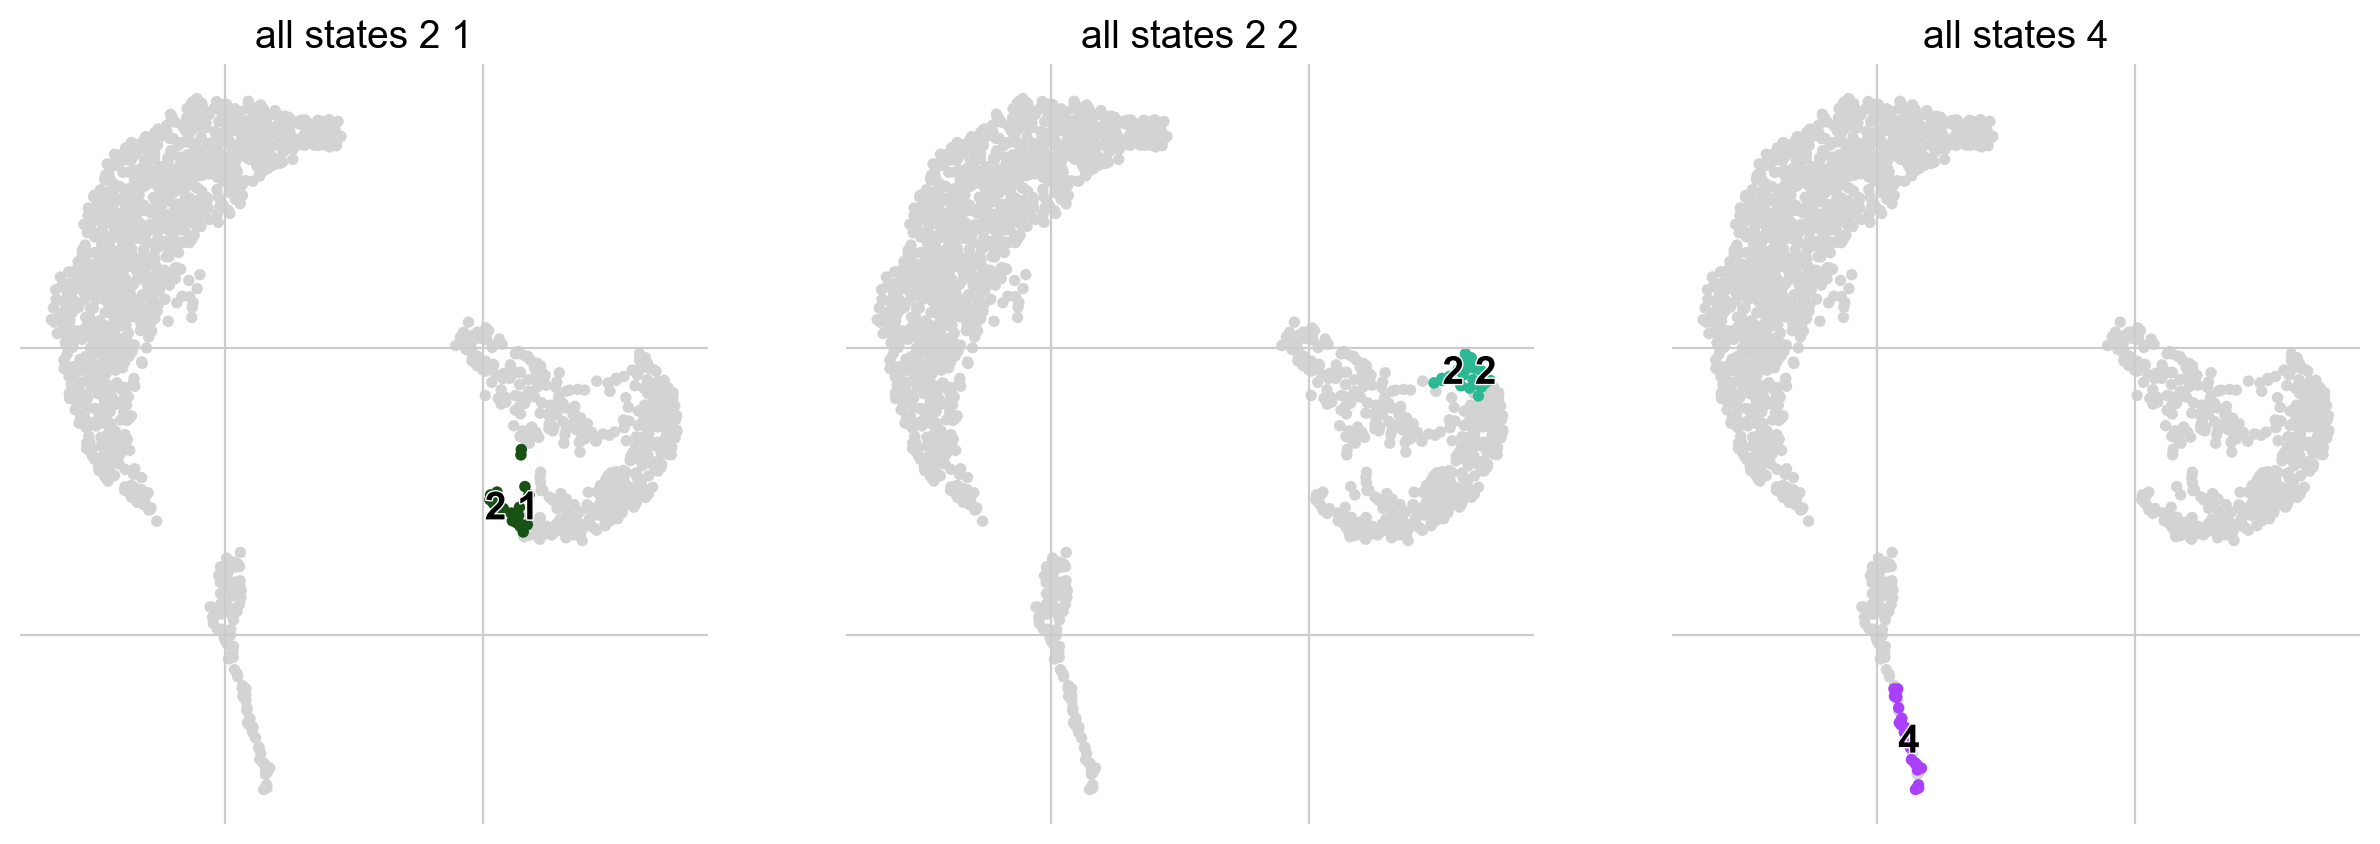

In [76]:
g.plot_macrostates(which = "all", same_plot=False)

## Calculating absorption probabilities

Analogously we can compute terminal states, the absorption probabilities and the absorption times.

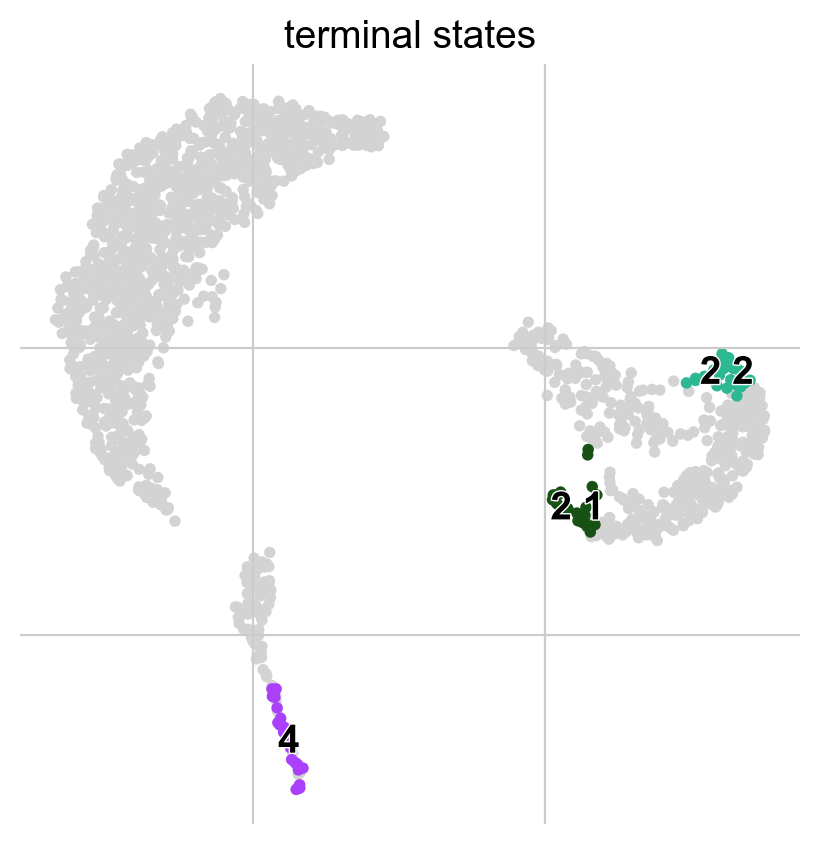

In [77]:
g.predict_terminal_states()
g.plot_macrostates(which="terminal")

  0%|          | 0/3 [00:00<?, ?/s]

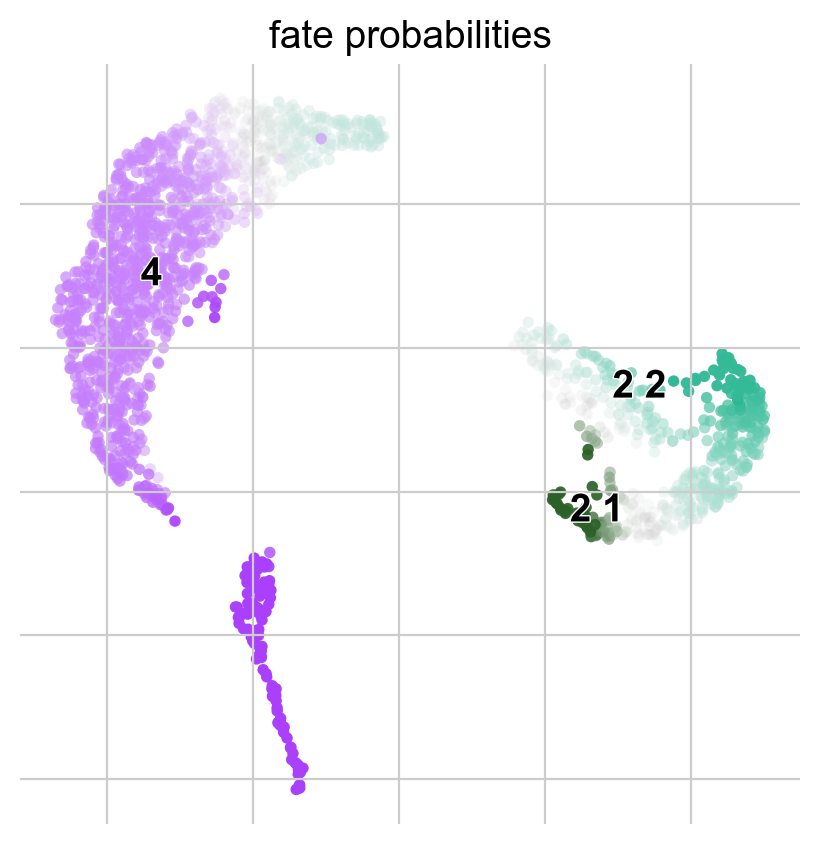

In [78]:
g.compute_fate_probabilities(preconditioner="ilu", tol=1e-15)
g.plot_fate_probabilities()

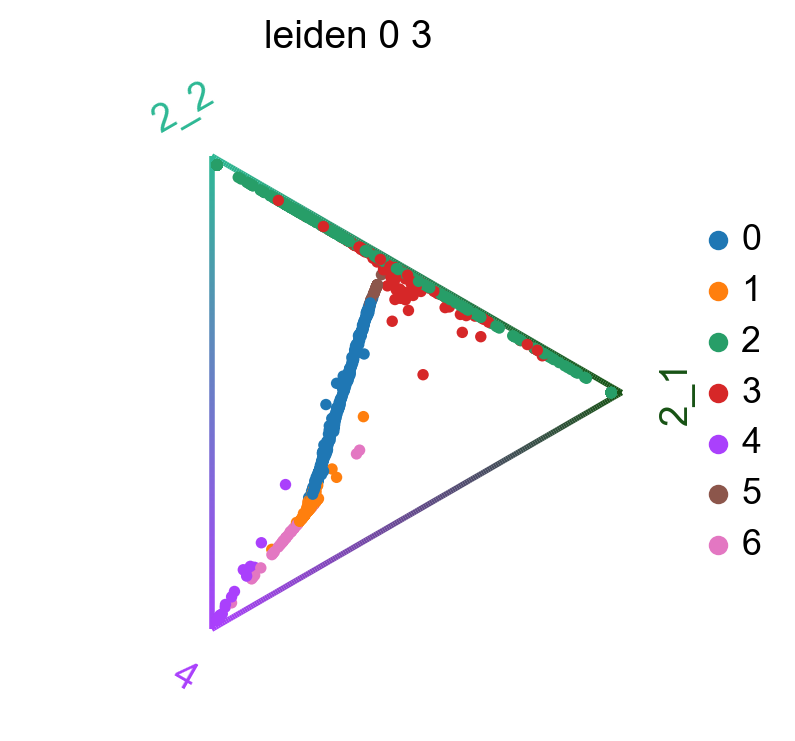

In [79]:
cr.pl.circular_projection(adata, keys="leiden_0_3", legend_loc="right")

## Extracting lineage drivers

Furthermore, just like above we can visualize the lineage drivers.

c:\Users\Knollr\Documents\github_ehrapy\.venv\Lib\site-packages\ehrapy\_settings.py:403: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
c:\Users\Knollr\Documents\github_ehrapy\.venv\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


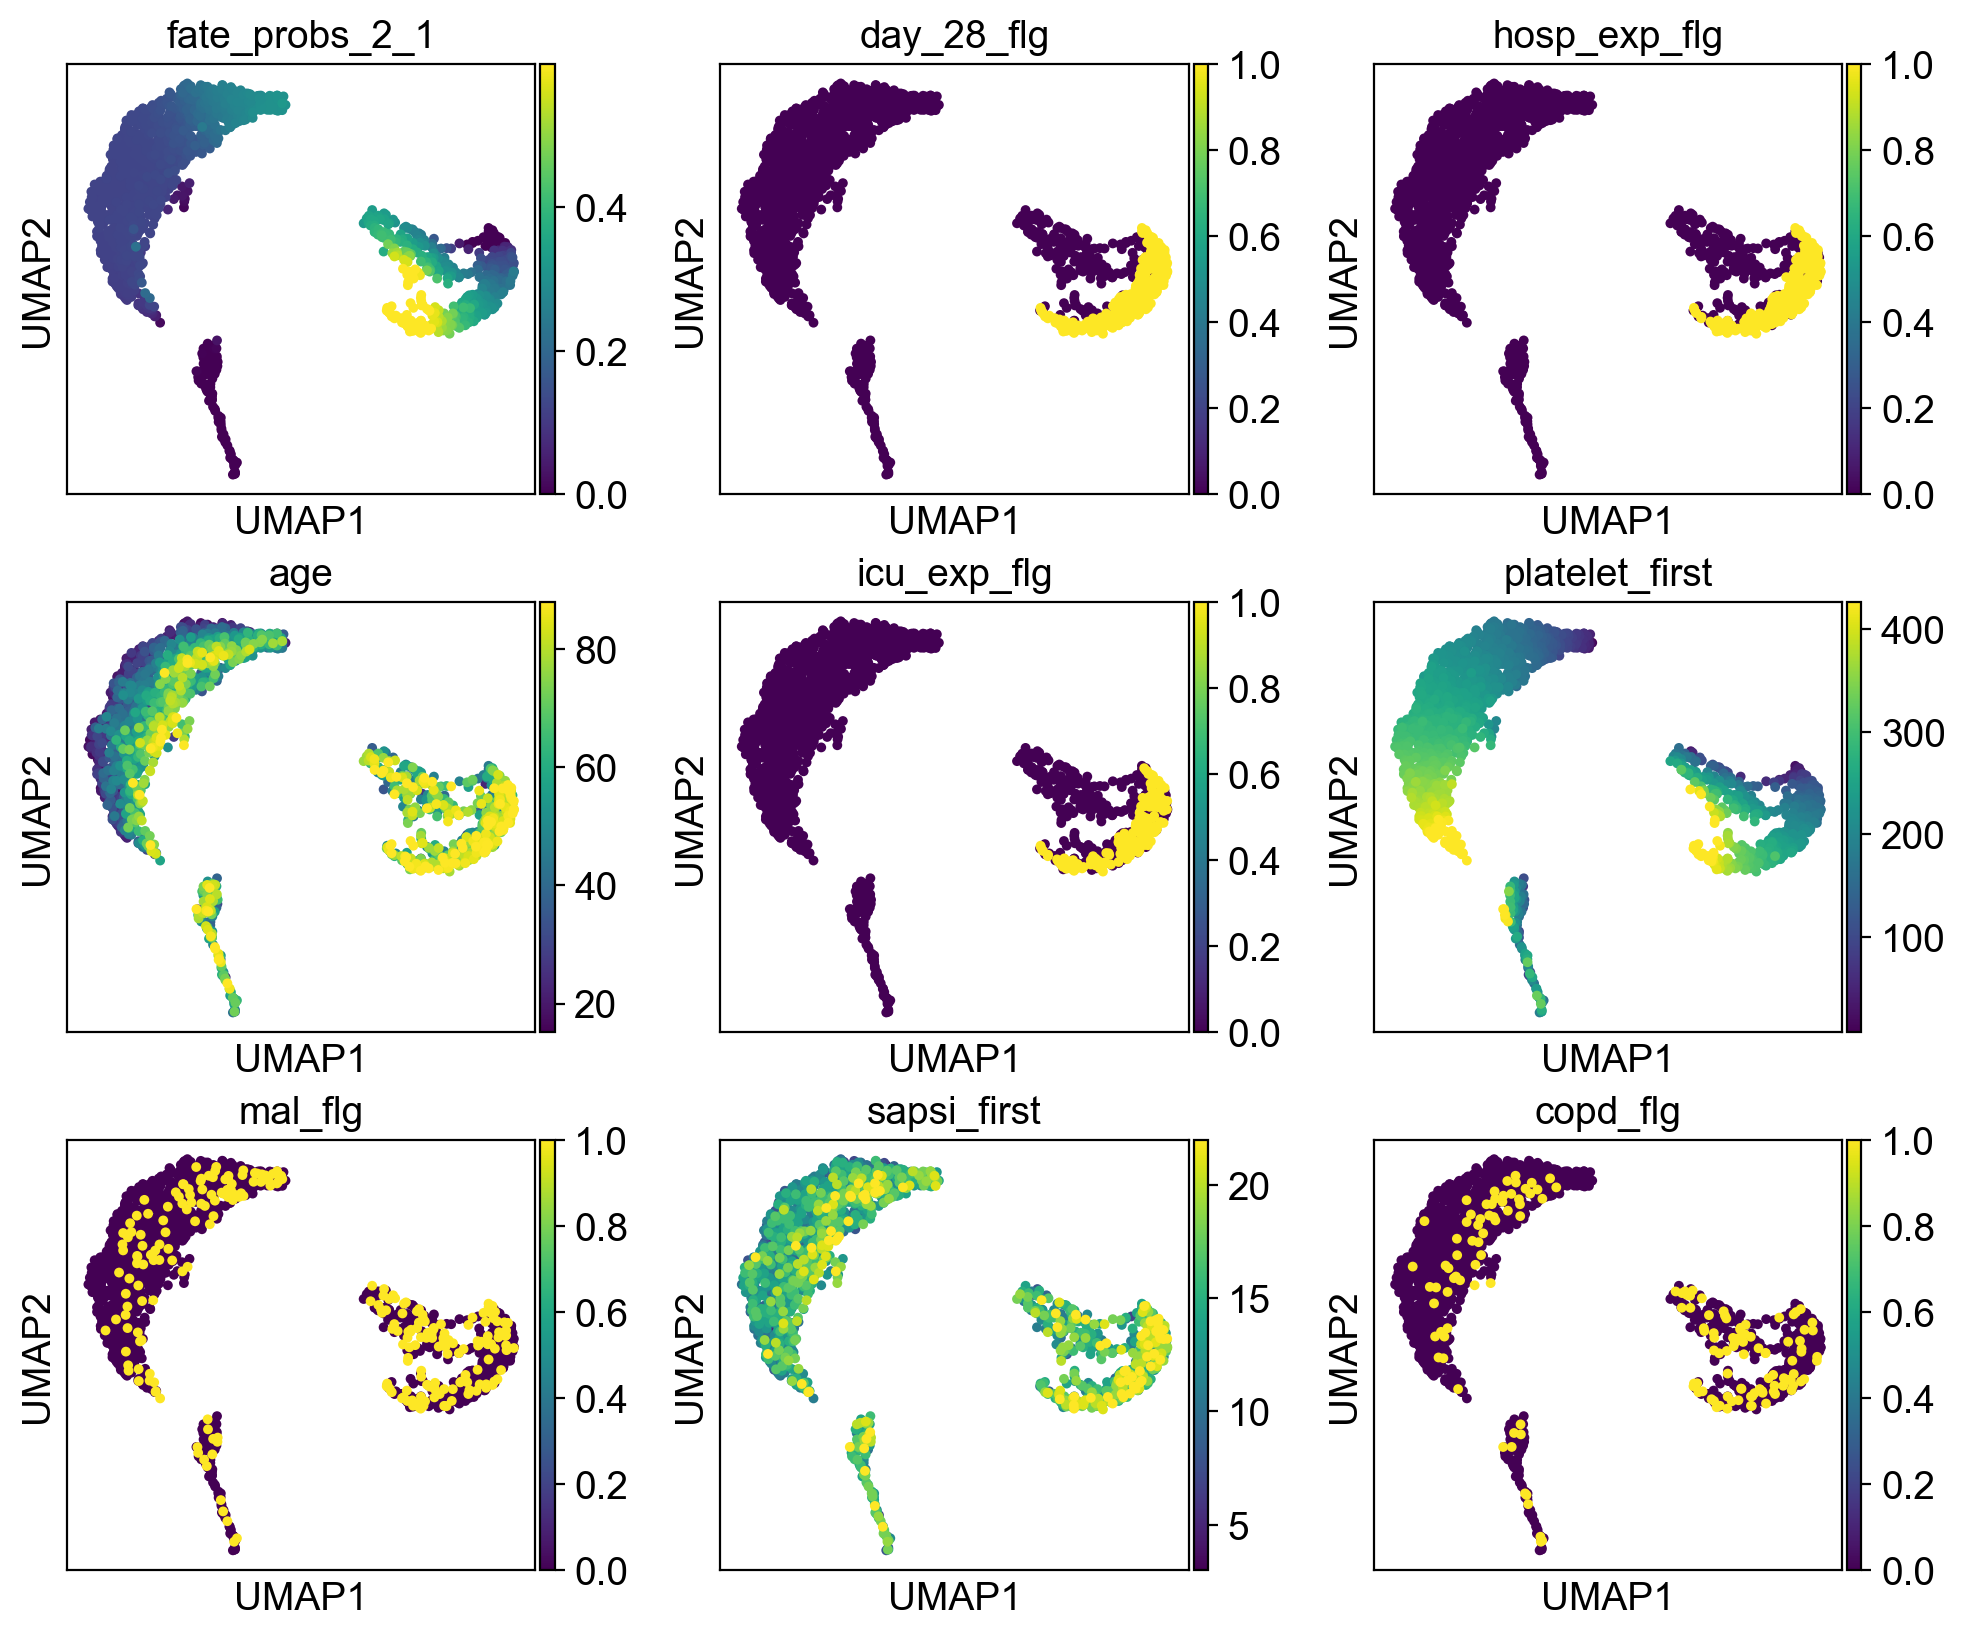

In [81]:
ep.settings.set_figure_params(figsize=(3, 3), dpi = 100)
drivers_2_2 = g.compute_lineage_drivers(lineages="2_2")
adata.obs["fate_probs_2_2"] = g.fate_probabilities["2_2"].X.flatten()

ep.pl.embedding(
    adata,
    basis="umap",
    color=["fate_probs_2_2"] + list(drivers_2_1.index[:8]),
    color_map="viridis",
    s=50,
    ncols=3,
    vmax="p96",
)

The primary lineage drivers for cluster 2_2 are for example `age` and `sapsi_first`.

### Determining feature trends

cellrank uses [Generalized Additive Models (GAMs)](https://cellrank.readthedocs.io/en/latest/api/cellrank.ul.models.GAM.html) to determine trends of features.

In [82]:
model = cr.models.GAM(adata)

  0%|          | 0/4 [00:00<?, ?gene/s]

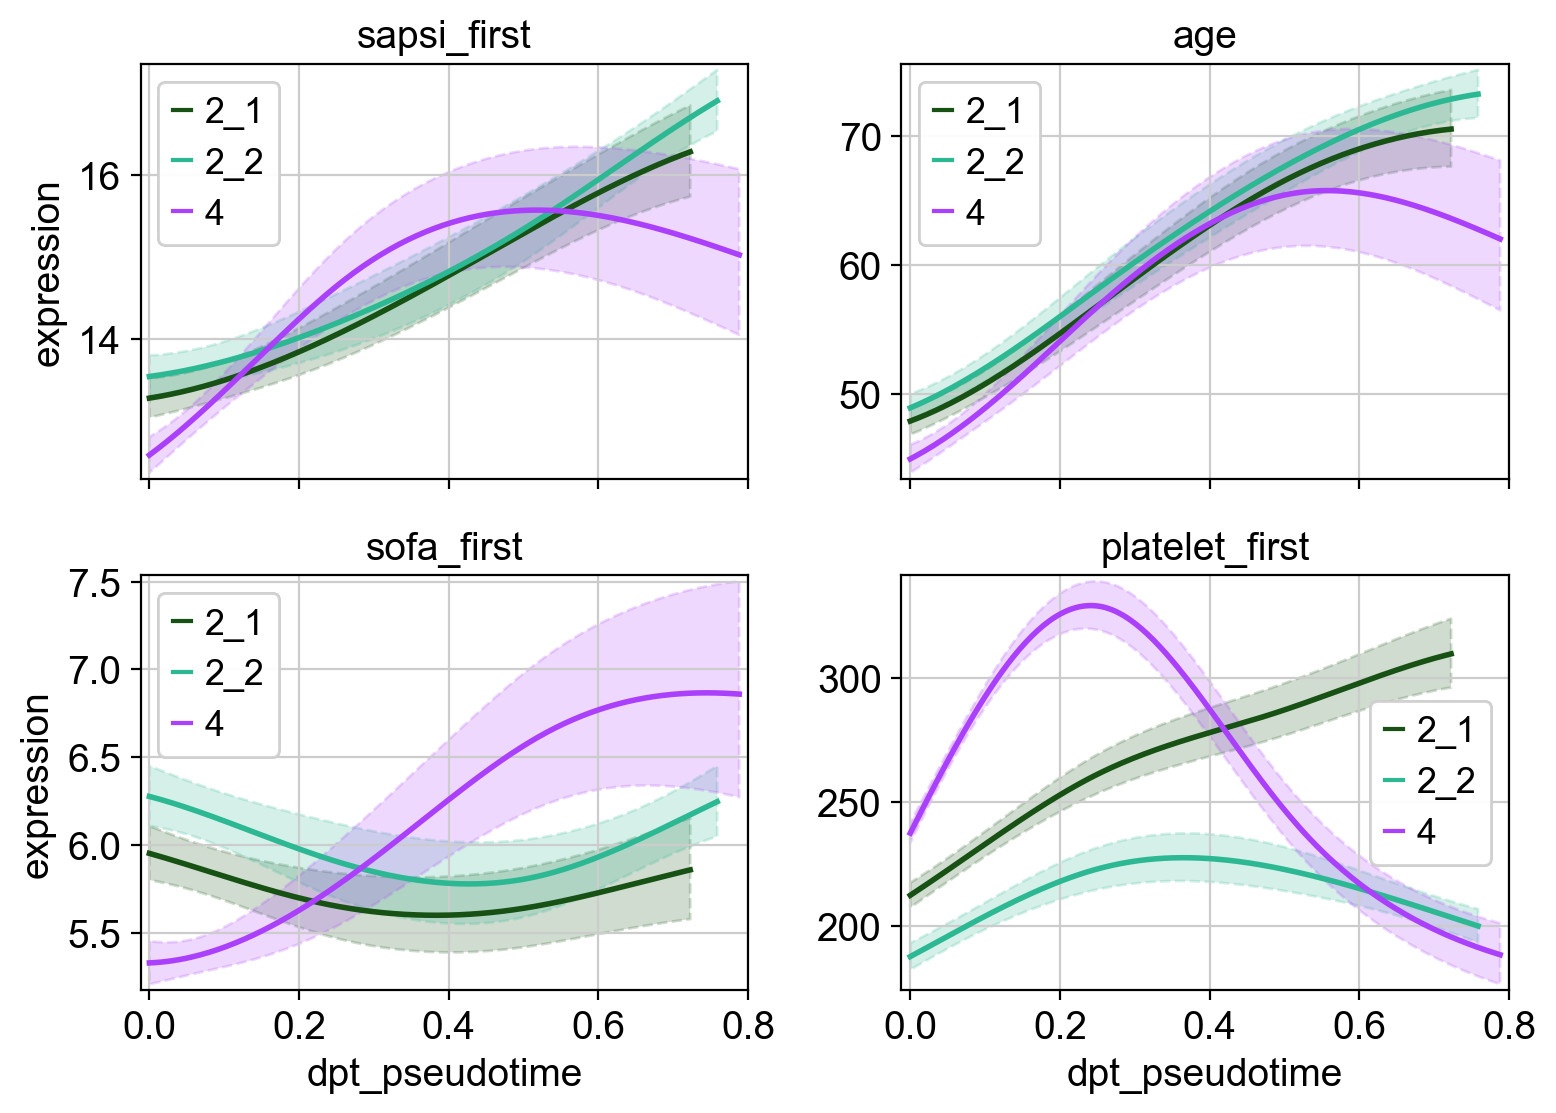

In [87]:
cr.pl.gene_trends(
    adata,
    model,
    ["sapsi_first", "age", "sofa_first", "platelet_first"],
    time_key="dpt_pseudotime",
    show_progress_bar=False,
    same_plot=True,
    ncols=2,
    hide_cells=True, 
    figsize=(8,6)
)

_________________

## Conclusion

Needs to be added. 

_________________

## References

* Raffa, J. (2016). Clinical data from the MIMIC-II database for a case study on indwelling arterial catheters (version 1.0). PhysioNet. https://doi.org/10.13026/C2NC7F.

* Raffa J.D., Ghassemi M., Naumann T., Feng M., Hsu D. (2016) Data Analysis. In: Secondary Analysis of Electronic Health Records. Springer, Cham

* Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

* Marius Lange, Volker Bergen, Michal Klein, Manu Setty, Bernhard Reuter, Mostafa Bakhti, Heiko Lickert, Meshal Ansari, Janine Schniering, Herbert B. Schiller, Dana Pe'er, and Fabian J. Theis. Cellrank for directed single-cell fate mapping. Nat. Methods, 2022. doi:10.1038/s41592-021-01346-6.

* Lars Velten, Simon F. Haas, Simon Raffel, Sandra Blaszkiewicz, Saiful Islam, Bianca P. Hennig, Christoph Hirche, Christoph Lutz, Eike C. Buss, Daniel Nowak, Tobias Boch, Wolf-Karsten Hofmann, Anthony D. Ho, Wolfgang Huber, Andreas Trumpp, Marieke A. G. Essers, and Lars M. Steinmetz. Human haematopoietic stem cell lineage commitment is a continuous process. Nature Cell Biology, 19(4):271–281, 2017. doi:10.1038/ncb3493.

* Bergen, V., Lange, M., Peidli, S. et al. Generalizing RNA velocity to transient cell states through dynamical modeling. Nat Biotechnol 38, 1408–1414 (2020). https://doi.org/10.1038/s41587-020-0591-3

_________________

## Package versions

In [49]:
ep.print_versions()

c:\Users\Knollr\Documents\github_ehrapy\.venv\Lib\site-packages\session_info\main.py:213: DeprecationWarning: Accessing attr.__version__ is deprecated and will be removed in a future release. Use importlib.metadata directly to query for attrs's packaging metadata.
  mod_version = _find_version(mod.__version__)


-----
ehrapy              0.5.0
rich                NA
session_info        1.0.0
-----
Levenshtein         0.21.1
PIL                 9.5.0
anndata             0.9.1
argcomplete         NA
astor               0.8.1
asttokens           NA
attr                23.1.0
autograd            NA
autograd_gamma      NA
backcall            0.2.0
bs4                 4.12.2
cachetools          5.3.1
category_encoders   2.6.1
cellrank            2.0.0
certifi             2023.05.07
cffi                1.15.1
charset_normalizer  3.1.0
colorama            0.4.6
comm                0.1.3
cvxopt              1.3.1
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
db_dtypes           1.1.1
debugpy             1.6.7
decorator           5.1.1
deep_translator     1.9.1
deepl               1.15.0
defusedxml          0.7.1
docrep              0.3.2
entrypoints         0.4
executing           1.2.0
fhiry               3.0.0
formulaic           0.6.2
future              0.18.3
google              NA
grpc                1.56.0
grpc_status         NA
h5py                3.9.0
html5lib            1.1
idna                3.4
igraph              0.10.4
interface_meta      1.3.0
ipykernel           6.23.3
ipython_genutils    0.2.0
ipywidgets          8.0.6
jedi                0.18.2
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.1
lifelines           0.27.7
llvmlite            0.40.1
matplotlib          3.7.1
matplotlib_inline   0.1.6
missingno           0.5.2
mpl_toolkits        NA
natsort             8.4.0
networkx            3.1
numba               0.57.1
numpy               1.24.3
packaging           23.1
pandas              1.5.3
parso               0.8.3
patsy               0.5.3
pickleshare         0.7.5
pkg_resources       NA
platformdirs        3.8.0
progressbar         4.2.0
prompt_toolkit      3.0.38
psutil              5.9.5
pure_eval           0.2.2
pyarrow             12.0.1
pyasn1              0.5.0
pyasn1_modules      0.3.0
pycparser           2.21
pydev_ipython       NA
pydevconsole        NA
pydevd              2.9.5
pydevd_file_utils   NA
pydevd_plugins      NA
pydevd_tracing      NA
pygam               0.8.0
pygments            2.15.1
pygpcca             1.0.4
pynndescent         0.5.10
pyparsing           3.1.0
python_utils        NA
pythoncom           NA
pytz                2023.3
pywin32_bootstrap   NA
pywin32_system32    NA
pywintypes          NA
rapidfuzz           2.15.1
requests            2.31.0
rsa                 4.9
scanpy              1.9.3
scipy               1.11.0
scvelo              0.2.5
seaborn             0.12.2
setuptools          68.0.0
six                 1.16.0
sklearn             1.2.2
soupsieve           2.4.1
sphinxcontrib       NA
stack_data          0.6.2
statsmodels         0.14.0
texttable           1.6.7
thefuzz             0.19.0
threadpoolctl       3.1.0
tornado             6.3.2
tqdm                4.65.0
traitlets           5.9.0
typing_extensions   NA
umap                0.5.3
urllib3             1.26.16
wcwidth             0.2.6
webencodings        0.5.1
win32api            NA
win32com            NA
wrapt               1.15.0
yaml                6.0
zipp                NA
zmq                 24.0.1
-----
IPython             8.14.0
jupyter_client      7.4.9
jupyter_core        5.3.1
notebook            6.5.4
-----
Python 3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]
Windows-10-10.0.19044-SP0
-----
Session information updated at 2023-08-08 13:31

In [50]:
cr.logging.print_versions()

cellrank==2.0.0 scanpy==1.9.3 anndata==0.9.1 numpy==1.24.3 numba==0.57.1 scipy==1.11.0 pandas==1.5.3 pygpcca==1.0.4 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 scvelo==0.2.5 pygam==0.8.0 matplotlib==3.7.1 seaborn==0.12.2
